In [1]:
import torch
import torch.nn as nn
from torch.nn import  functional as F
from torch.nn.parameter import Parameter
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mamba_ssm import Mamba

In [2]:
!nvidia-smi

Thu Feb 22 11:46:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   35C    P8              19W / 215W |   1073MiB /  8192MiB |      3%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
os.chdir('..')
os.getcwd()

'/home/linh/projects/IConNet'

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
import traceback
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
from torch.nn.utils.rnn import pad_sequence

In [7]:
data_dir = "../data/data_preprocessed/crema_d/preprocessed/" 
data_x = np.load(f"{data_dir}crema_d.trill_layer19.train.npy", allow_pickle=True)
data_x.shape

(5144, 12288)

In [8]:
x_train = [torch.tensor(d.T.real, dtype=torch.float) for d in data_x]
x_train = pad_sequence(x_train, batch_first=True)
x_train.shape

torch.Size([5144, 12288])

In [9]:
data_x = np.load(f"{data_dir}crema_d.trill_layer19.test.npy", allow_pickle=True)
x_test = [torch.tensor(d.T.real, dtype=torch.float) for d in data_x]
x_test = pad_sequence(x_test, batch_first=True)
x_test.shape

torch.Size([1556, 12288])

In [10]:
classnames = np.load(f'{data_dir}crema_d.classnames.npy', allow_pickle=True)
y_train = np.load(f'{data_dir}crema_d.labels.train.npy', allow_pickle=True)
y_test = np.load(f'{data_dir}crema_d.labels.test.npy', allow_pickle=True)
print(classnames)

['NEU' 'HAP' 'SAD' 'ANG' 'FEA' 'DIS']


In [11]:
np.unique(y_test)

array([0, 1, 2, 3, 4, 5], dtype=int16)

In [12]:
labels = ['ANG', 'NEU', 'SAD', 'HAP']

def label_filter(idx):
    return classnames[idx] in labels

def label_to_index(idx):
    return labels.index(classnames[idx])
    
filtered_idx = [label_filter(idx) for idx in y_train]
x_train = x_train[filtered_idx]
y_train = [label_to_index(idx) for idx in y_train[filtered_idx]]
print(x_train.shape)

filtered_idx = [label_filter(idx) for idx in y_test]
x_test = x_test[filtered_idx]
y_test = [label_to_index(idx) for idx in y_test[filtered_idx]]
print(x_test.shape)

torch.Size([3387, 12288])
torch.Size([1025, 12288])


In [13]:
from torch.utils.data import TensorDataset, DataLoader

def create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=32):
    x_train = x_train[:, None ,:]
    y_train = torch.tensor(y_train, dtype=torch.int64)
    x_test = x_test[:, None, :]
    y_test = torch.tensor(y_test, dtype=torch.int64)
    train_data = TensorDataset(x_train, y_train)
    test_data = TensorDataset(x_test, y_test)
    
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
    test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)
    return train_loader, test_loader

In [14]:
batch_size = 32
train_loader, test_loader = create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=batch_size)

In [15]:
from IConNet.nn.model import M12
from omegaconf import OmegaConf as ocf
from IConNet.visualizer import visualize_model

model_config_path = 'config/model/m12_debug.yaml'
model_config = ocf.load(model_config_path)
print(ocf.to_yaml(model_config))
model = M12(config=model_config,
           n_input=1, n_output=len(labels))
print(model)

print(f'total parameters: {visualize_model.count_parameters(model)}')
print(f'FE parameters: {visualize_model.count_parameters(model.fe_blocks)}')

name: M12_debug
description: FirConv sequential for iemocap
fe:
  n_block: 2
  n_channel:
  - 64
  - 32
  kernel_size:
  - 63
  - 31
  stride:
  - 4
  - 4
  window_k:
  - 5
  - 9
  residual_connection_type: stack
  pooling: false
  filter_type: firwin
  conv_mode: fftconv
  norm_type: LocalResponseNorm
seq:
  n_block: 1
  n_channel: 48
  pooling: max
  use_context: false
  bidirectional: false
cls:
  n_block: 2
  n_hidden_dim:
  - 256
  - 256
  norm_type: LayerNorm

M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
         

In [16]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [17]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [18]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|▎                                                                                                                                                                             | 0.014598540145985401/10 [00:00<05:45, 34.64s/it]

Train Epoch: 1 [0/3387 (0%)]	Loss: 1.430367
Mem before-during-after: 529408 507427328 20813312


  3%|█████▍                                                                                                                                                                          | 0.3065693430656933/10 [00:07<03:43, 23.07s/it]

Train Epoch: 1 [1280/3387 (38%)]	Loss: 1.378067
Mem before-during-after: 20813312 516430848 20813312


  6%|██████████▌                                                                                                                                                                      | 0.598540145985401/10 [00:13<03:37, 23.09s/it]

Train Epoch: 1 [2560/3387 (76%)]	Loss: 1.309744
Mem before-during-after: 20813312 516430848 20813312


 10%|█████████████████▋                                                                                                                                                              | 1.0072992700729917/10 [00:22<03:11, 21.28s/it]


Test Epoch: 1	Accuracy: 449/1024 (44%)

Train Epoch: 2 [0/3387 (0%)]	Loss: 1.329693
Mem before-during-after: 20809216 516529152 20813312


 13%|██████████████████████▉                                                                                                                                                         | 1.3065693430656966/10 [00:29<03:16, 22.56s/it]

Train Epoch: 2 [1280/3387 (38%)]	Loss: 1.339074
Mem before-during-after: 20813312 517053440 20813312


 16%|████████████████████████████▏                                                                                                                                                   | 1.5985401459854087/10 [00:36<03:07, 22.30s/it]

Train Epoch: 2 [2560/3387 (76%)]	Loss: 1.220844
Mem before-during-after: 20813312 517053440 20813312


 20%|███████████████████████████████████▎                                                                                                                                            | 2.0072992700730055/10 [00:45<02:52, 21.52s/it]


Test Epoch: 2	Accuracy: 507/1024 (49%)

Train Epoch: 3 [0/3387 (0%)]	Loss: 1.152749
Mem before-during-after: 20809216 516529152 20813312


 23%|████████████████████████████████████████▌                                                                                                                                       | 2.3065693430657013/10 [00:51<02:56, 22.95s/it]

Train Epoch: 3 [1280/3387 (38%)]	Loss: 1.144251
Mem before-during-after: 20813312 517053440 20813312


 26%|█████████████████████████████████████████████▋                                                                                                                                  | 2.5985401459854045/10 [00:58<02:43, 22.16s/it]

Train Epoch: 3 [2560/3387 (76%)]	Loss: 1.042787
Mem before-during-after: 20813312 517053440 20813312


 30%|█████████████████████████████████████████████████████▏                                                                                                                           | 3.007299270072989/10 [01:07<02:28, 21.21s/it]


Test Epoch: 3	Accuracy: 513/1024 (50%)

Train Epoch: 4 [0/3387 (0%)]	Loss: 1.008220
Mem before-during-after: 20809216 516529152 20813312


 33%|██████████████████████████████████████████████████████████▌                                                                                                                      | 3.306569343065685/10 [01:13<02:30, 22.46s/it]

Train Epoch: 4 [1280/3387 (38%)]	Loss: 1.144546
Mem before-during-after: 20813312 517053440 20813312


 36%|███████████████████████████████████████████████████████████████▋                                                                                                                 | 3.598540145985388/10 [01:20<02:26, 22.84s/it]

Train Epoch: 4 [2560/3387 (76%)]	Loss: 1.072496
Mem before-during-after: 20813312 517053440 20813312


 40%|██████████████████████████████████████████████████████████████████████▉                                                                                                          | 4.007299270072973/10 [01:29<02:10, 21.82s/it]


Test Epoch: 4	Accuracy: 547/1024 (53%)

Train Epoch: 5 [0/3387 (0%)]	Loss: 1.159688
Mem before-during-after: 20809216 516529152 20813312


 43%|████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 4.306569343065687/10 [01:35<02:07, 22.43s/it]

Train Epoch: 5 [1280/3387 (38%)]	Loss: 1.189128
Mem before-during-after: 20813312 517053440 20813312


 46%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 4.598540145985408/10 [01:42<01:59, 22.19s/it]

Train Epoch: 5 [2560/3387 (76%)]	Loss: 1.151644
Mem before-during-after: 20813312 517053440 20813312


 50%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 5.007299270073017/10 [01:51<01:45, 21.21s/it]


Test Epoch: 5	Accuracy: 516/1024 (50%)

Train Epoch: 6 [0/3387 (0%)]	Loss: 0.880934
Mem before-during-after: 20809216 516529152 20813312


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 5.306569343065731/10 [01:57<01:43, 22.10s/it]

Train Epoch: 6 [1280/3387 (38%)]	Loss: 1.063957
Mem before-during-after: 20813312 517053440 20813312


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 5.598540145985452/10 [02:04<01:37, 22.14s/it]

Train Epoch: 6 [2560/3387 (76%)]	Loss: 0.926676
Mem before-during-after: 20813312 517053440 20813312


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 6.007299270073061/10 [02:13<01:24, 21.16s/it]


Test Epoch: 6	Accuracy: 549/1024 (54%)

Train Epoch: 7 [0/3387 (0%)]	Loss: 0.982103
Mem before-during-after: 20809216 516529152 20813312


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 6.306569343065775/10 [02:19<01:23, 22.56s/it]

Train Epoch: 7 [1280/3387 (38%)]	Loss: 1.058360
Mem before-during-after: 20813312 517053440 20813312


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 6.598540145985496/10 [02:26<01:15, 22.31s/it]

Train Epoch: 7 [2560/3387 (76%)]	Loss: 1.141221
Mem before-during-after: 20813312 517053440 20813312


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 7.007299270073106/10 [02:35<01:03, 21.12s/it]


Test Epoch: 7	Accuracy: 581/1024 (57%)

Train Epoch: 8 [0/3387 (0%)]	Loss: 1.192911
Mem before-during-after: 20809216 516529152 20813312


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 7.30656934306582/10 [02:42<01:01, 22.80s/it]

Train Epoch: 8 [1280/3387 (38%)]	Loss: 1.185882
Mem before-during-after: 20813312 517053440 20813312


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 7.598540145985541/10 [02:48<00:54, 22.53s/it]

Train Epoch: 8 [2560/3387 (76%)]	Loss: 1.075737
Mem before-during-after: 20813312 517053440 20813312


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 8.00729927007315/10 [02:57<00:42, 21.10s/it]


Test Epoch: 8	Accuracy: 585/1024 (57%)

Train Epoch: 9 [0/3387 (0%)]	Loss: 0.951369
Mem before-during-after: 20809216 516529152 20813312


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 8.306569343065863/10 [03:04<00:37, 22.13s/it]

Train Epoch: 9 [1280/3387 (38%)]	Loss: 1.111013
Mem before-during-after: 20813312 517053440 20813312


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 8.598540145985584/10 [03:10<00:31, 22.22s/it]

Train Epoch: 9 [2560/3387 (76%)]	Loss: 0.775665
Mem before-during-after: 20813312 517053440 20813312


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 9.007299270073194/10 [03:19<00:21, 21.25s/it]


Test Epoch: 9	Accuracy: 592/1024 (58%)

Train Epoch: 10 [0/3387 (0%)]	Loss: 0.850180
Mem before-during-after: 20809216 516529152 20813312


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 9.306569343065908/10 [03:26<00:15, 22.99s/it]

Train Epoch: 10 [1280/3387 (38%)]	Loss: 0.938752
Mem before-during-after: 20813312 517053440 20813312


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 9.598540145985629/10 [03:32<00:08, 22.10s/it]

Train Epoch: 10 [2560/3387 (76%)]	Loss: 1.277273
Mem before-during-after: 20813312 517053440 20813312


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 9.992700729927252/10 [03:41<00:00, 20.46s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10.000000000000245/10 [03:41<00:00, 22.12s/it]


Test Epoch: 10	Accuracy: 587/1024 (57%)



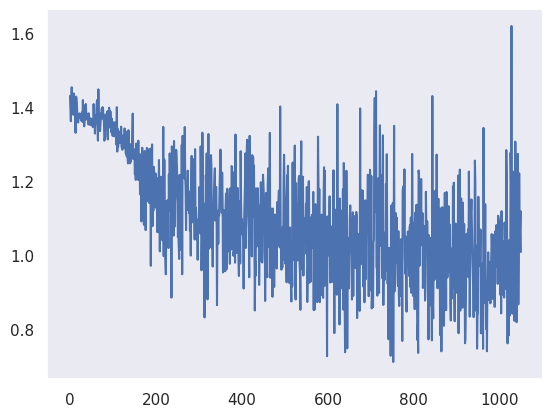

In [19]:
plt.plot(train_losses)

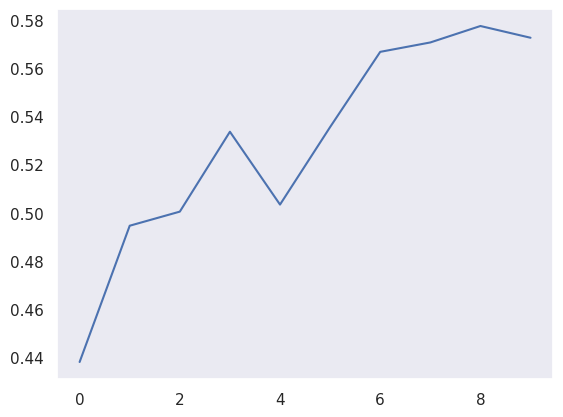

In [20]:
plt.plot(test_accuracy)

In [21]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s': MulticlassF1Score(num_classes=n),  
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc': MulticlassAUROC(num_classes=n, average=None, thresholds=None)
    }
    # , compute_groups=[['acc', 'f1s', 'wap'], ['uap', 'uar']]
                              ).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [22]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 586/1024 (0.5723)
{'acc_detail': tensor([0.7481, 0.3904, 0.6642, 0.4604], device='cuda:0'),
 'acc_unweighted': tensor(0.5657, device='cuda:0'),
 'acc_weighted': tensor(0.5723, device='cuda:0'),
 'f1s': tensor(0.5681, device='cuda:0'),
 'f1s_detail': tensor([0.7082, 0.4208, 0.7169, 0.4266], device='cuda:0'),
 'precision_detail': tensor([0.6723, 0.4564, 0.7788, 0.3974], device='cuda:0'),
 'recall_detail': tensor([0.7481, 0.3904, 0.6642, 0.4604], device='cuda:0'),
 'rocauc': tensor([0.9132, 0.7510, 0.9196, 0.7287], device='cuda:0'),
 'uar': tensor(0.5657, device='cuda:0'),
 'wap': tensor(0.5806, device='cuda:0')}


tensor([[199,   5,   0,  62],
        [ 10,  89,  34,  95],
        [  1,  60, 176,  28],
        [ 86,  41,  16, 122]], device='cuda:0')

In [23]:
model_path = '../models_cremad4_trill19/cremad_label4_trill19_m12new_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [24]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
best_accuracy = min(test_accuracy)
model_path_prefix = '../models_cremad4_trill19/cremad_label4_trill19_m12new_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.00005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

 22%|██████████████████████████████████████▋                                                                                                                                         | 11.007299270073283/50 [04:33<15:39, 24.10s/it]


Test Epoch: 21	Accuracy: 643/1024 (63%)

saved model: ../models_cremad4_trill19/cremad_label4_trill19_m12new_best_21epoch.pt
Train Epoch: 22 [0/3387 (0%)]	Loss: 0.782365
Mem before-during-after: 20864512 516584448 20868608


 23%|███████████████████████████████████████▊                                                                                                                                        | 11.306569343065997/50 [04:41<16:18, 25.30s/it]

Train Epoch: 22 [1280/3387 (38%)]	Loss: 0.802272
Mem before-during-after: 20868608 517108736 20868608


 23%|████████████████████████████████████████▊                                                                                                                                       | 11.598540145985718/50 [04:48<16:17, 25.45s/it]

Train Epoch: 22 [2560/3387 (76%)]	Loss: 1.043604
Mem before-during-after: 20868608 517108736 20868608


 24%|██████████████████████████████████████████▎                                                                                                                                     | 12.007299270073327/50 [04:58<15:29, 24.46s/it]


Test Epoch: 22	Accuracy: 655/1024 (64%)

saved model: ../models_cremad4_trill19/cremad_label4_trill19_m12new_best_22epoch.pt
Train Epoch: 23 [0/3387 (0%)]	Loss: 0.996385
Mem before-during-after: 20864512 516584448 20868608


 25%|███████████████████████████████████████████▎                                                                                                                                    | 12.306569343066041/50 [05:06<15:54, 25.33s/it]

Train Epoch: 23 [1280/3387 (38%)]	Loss: 1.005159
Mem before-during-after: 20868608 517108736 20868608


 25%|████████████████████████████████████████████▎                                                                                                                                   | 12.598540145985762/50 [05:13<15:45, 25.28s/it]

Train Epoch: 23 [2560/3387 (76%)]	Loss: 0.912285
Mem before-during-after: 20868608 517108736 20868608


 26%|█████████████████████████████████████████████▊                                                                                                                                  | 13.007299270073371/50 [05:23<14:50, 24.08s/it]


Test Epoch: 23	Accuracy: 605/1024 (59%)

Train Epoch: 24 [0/3387 (0%)]	Loss: 1.195190
Mem before-during-after: 20864512 516584448 20868608


 27%|██████████████████████████████████████████████▊                                                                                                                                 | 13.306569343066085/50 [05:31<15:19, 25.06s/it]

Train Epoch: 24 [1280/3387 (38%)]	Loss: 0.795774
Mem before-during-after: 20868608 517108736 20868608


 27%|███████████████████████████████████████████████▊                                                                                                                                | 13.598540145985806/50 [05:39<15:36, 25.72s/it]

Train Epoch: 24 [2560/3387 (76%)]	Loss: 0.825303
Mem before-during-after: 20868608 517108736 20868608


 28%|█████████████████████████████████████████████████▎                                                                                                                              | 14.007299270073416/50 [05:49<14:39, 24.44s/it]


Test Epoch: 24	Accuracy: 506/1024 (49%)

Train Epoch: 25 [0/3387 (0%)]	Loss: 0.946442
Mem before-during-after: 20864512 516584448 20868608


 29%|██████████████████████████████████████████████████▋                                                                                                                              | 14.30656934306613/50 [05:56<15:16, 25.67s/it]

Train Epoch: 25 [1280/3387 (38%)]	Loss: 0.776957
Mem before-during-after: 20868608 517108736 20868608


 29%|███████████████████████████████████████████████████▋                                                                                                                             | 14.59854014598585/50 [06:04<15:03, 25.51s/it]

Train Epoch: 25 [2560/3387 (76%)]	Loss: 0.906307
Mem before-during-after: 20868608 517108736 20868608


 30%|█████████████████████████████████████████████████████▏                                                                                                                           | 15.00729927007346/50 [06:14<14:13, 24.39s/it]


Test Epoch: 25	Accuracy: 586/1024 (57%)

Train Epoch: 26 [0/3387 (0%)]	Loss: 0.733635
Mem before-during-after: 20864512 516584448 20868608


 31%|█████████████████████████████████████████████████████▉                                                                                                                          | 15.306569343066174/50 [06:21<14:50, 25.66s/it]

Train Epoch: 26 [1280/3387 (38%)]	Loss: 0.879414
Mem before-during-after: 20868608 517108736 20868608


 31%|██████████████████████████████████████████████████████▉                                                                                                                         | 15.598540145985895/50 [06:29<14:32, 25.35s/it]

Train Epoch: 26 [2560/3387 (76%)]	Loss: 0.698320
Mem before-during-after: 20868608 517108736 20868608


 32%|████████████████████████████████████████████████████████▎                                                                                                                       | 16.007299270073503/50 [06:39<13:26, 23.73s/it]


Test Epoch: 26	Accuracy: 605/1024 (59%)

Train Epoch: 27 [0/3387 (0%)]	Loss: 0.878343
Mem before-during-after: 20864512 516584448 20868608


 33%|█████████████████████████████████████████████████████████▍                                                                                                                      | 16.306569343066144/50 [06:46<13:58, 24.89s/it]

Train Epoch: 27 [1280/3387 (38%)]	Loss: 0.978801
Mem before-during-after: 20868608 517108736 20868608


 33%|██████████████████████████████████████████████████████████▍                                                                                                                     | 16.598540145985794/50 [06:54<14:18, 25.69s/it]

Train Epoch: 27 [2560/3387 (76%)]	Loss: 1.217775
Mem before-during-after: 20868608 517108736 20868608


 34%|███████████████████████████████████████████████████████████▊                                                                                                                    | 17.007299270073304/50 [07:04<13:28, 24.51s/it]


Test Epoch: 27	Accuracy: 638/1024 (62%)

Train Epoch: 28 [0/3387 (0%)]	Loss: 0.761524
Mem before-during-after: 20864512 516584448 20868608


 35%|████████████████████████████████████████████████████████████▉                                                                                                                   | 17.306569343065945/50 [07:11<13:43, 25.18s/it]

Train Epoch: 28 [1280/3387 (38%)]	Loss: 1.023829
Mem before-during-after: 20868608 517108736 20868608


 35%|█████████████████████████████████████████████████████████████▉                                                                                                                  | 17.598540145985595/50 [07:19<13:25, 24.86s/it]

Train Epoch: 28 [2560/3387 (76%)]	Loss: 0.666140
Mem before-during-after: 20868608 517108736 20868608


 36%|███████████████████████████████████████████████████████████████▍                                                                                                                | 18.007299270073105/50 [07:28<12:44, 23.88s/it]


Test Epoch: 28	Accuracy: 647/1024 (63%)

Train Epoch: 29 [0/3387 (0%)]	Loss: 0.775436
Mem before-during-after: 20864512 516584448 20868608


 37%|████████████████████████████████████████████████████████████████▍                                                                                                               | 18.306569343065746/50 [07:36<13:13, 25.04s/it]

Train Epoch: 29 [1280/3387 (38%)]	Loss: 0.935648
Mem before-during-after: 20868608 517108736 20868608


 37%|█████████████████████████████████████████████████████████████████▍                                                                                                              | 18.598540145985396/50 [07:43<13:20, 25.50s/it]

Train Epoch: 29 [2560/3387 (76%)]	Loss: 0.986236
Mem before-during-after: 20868608 517108736 20868608


 38%|██████████████████████████████████████████████████████████████████▉                                                                                                             | 19.007299270072906/50 [07:53<12:27, 24.10s/it]


Test Epoch: 29	Accuracy: 614/1024 (60%)

Train Epoch: 30 [0/3387 (0%)]	Loss: 1.014664
Mem before-during-after: 20864512 516584448 20868608


 39%|███████████████████████████████████████████████████████████████████▉                                                                                                            | 19.306569343065547/50 [08:01<12:49, 25.08s/it]

Train Epoch: 30 [1280/3387 (38%)]	Loss: 0.705876
Mem before-during-after: 20868608 517108736 20868608


 39%|████████████████████████████████████████████████████████████████████▉                                                                                                           | 19.598540145985197/50 [08:08<13:04, 25.82s/it]

Train Epoch: 30 [2560/3387 (76%)]	Loss: 0.925413
Mem before-during-after: 20868608 517108736 20868608


 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                         | 20.007299270072707/50 [08:18<11:56, 23.87s/it]


Test Epoch: 30	Accuracy: 643/1024 (63%)

Train Epoch: 31 [0/3387 (0%)]	Loss: 0.882185
Mem before-during-after: 20864512 516584448 20868608


 41%|███████████████████████████████████████████████████████████████████████▍                                                                                                        | 20.306569343065348/50 [08:26<12:25, 25.11s/it]

Train Epoch: 31 [1280/3387 (38%)]	Loss: 0.774467
Mem before-during-after: 20868608 517108736 20868608


 41%|████████████████████████████████████████████████████████████████████████▌                                                                                                       | 20.598540145984998/50 [08:33<12:45, 26.03s/it]

Train Epoch: 31 [2560/3387 (76%)]	Loss: 0.902733
Mem before-during-after: 20868608 517108736 20868608


 42%|█████████████████████████████████████████████████████████████████████████▉                                                                                                      | 21.007299270072508/50 [08:44<11:57, 24.74s/it]


Test Epoch: 31	Accuracy: 633/1024 (62%)

Train Epoch: 32 [0/3387 (0%)]	Loss: 0.777728
Mem before-during-after: 20864512 516584448 20868608


 43%|███████████████████████████████████████████████████████████████████████████▍                                                                                                     | 21.30656934306515/50 [08:51<11:56, 24.98s/it]

Train Epoch: 32 [1280/3387 (38%)]	Loss: 0.820420
Mem before-during-after: 20868608 517108736 20868608


 43%|████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 21.5985401459848/50 [08:58<11:55, 25.19s/it]

Train Epoch: 32 [2560/3387 (76%)]	Loss: 0.838287
Mem before-during-after: 20868608 517108736 20868608


 44%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 22.00729927007231/50 [09:08<11:12, 24.03s/it]


Test Epoch: 32	Accuracy: 641/1024 (63%)

Train Epoch: 33 [0/3387 (0%)]	Loss: 0.886376
Mem before-during-after: 20864512 516584448 20868608


 45%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 22.30656934306495/50 [09:16<11:59, 25.98s/it]

Train Epoch: 33 [1280/3387 (38%)]	Loss: 0.760069
Mem before-during-after: 20868608 517108736 20868608


 45%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 22.5985401459846/50 [09:23<11:31, 25.23s/it]

Train Epoch: 33 [2560/3387 (76%)]	Loss: 0.783355
Mem before-during-after: 20868608 517108736 20868608


 46%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 23.00729927007211/50 [09:33<10:46, 23.95s/it]


Test Epoch: 33	Accuracy: 626/1024 (61%)

Train Epoch: 34 [0/3387 (0%)]	Loss: 0.871098
Mem before-during-after: 20864512 516584448 20868608


 47%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 23.30656934306475/50 [09:41<11:13, 25.23s/it]

Train Epoch: 34 [1280/3387 (38%)]	Loss: 0.771853
Mem before-during-after: 20868608 517108736 20868608


 47%|████████████████████████████████████████████████████████████████████████████████████                                                                                              | 23.5985401459844/50 [09:48<11:03, 25.14s/it]

Train Epoch: 34 [2560/3387 (76%)]	Loss: 0.843833
Mem before-during-after: 20868608 517108736 20868608


 48%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 24.00729927007191/50 [09:58<10:29, 24.21s/it]


Test Epoch: 34	Accuracy: 637/1024 (62%)

Train Epoch: 35 [0/3387 (0%)]	Loss: 1.023746
Mem before-during-after: 20864512 516584448 20868608


 49%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 24.306569343064552/50 [10:05<10:44, 25.09s/it]

Train Epoch: 35 [1280/3387 (38%)]	Loss: 0.747802
Mem before-during-after: 20868608 517108736 20868608


 49%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 24.598540145984202/50 [10:13<10:38, 25.12s/it]

Train Epoch: 35 [2560/3387 (76%)]	Loss: 0.961935
Mem before-during-after: 20868608 517108736 20868608


 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 25.007299270071712/50 [10:23<10:00, 24.01s/it]


Test Epoch: 35	Accuracy: 627/1024 (61%)

Train Epoch: 36 [0/3387 (0%)]	Loss: 0.935951
Mem before-during-after: 20864512 516584448 20868608


 51%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 25.306569343064353/50 [10:30<10:23, 25.26s/it]

Train Epoch: 36 [1280/3387 (38%)]	Loss: 0.845444
Mem before-during-after: 20868608 517108736 20868608


 51%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 25.598540145984003/50 [10:38<10:12, 25.10s/it]

Train Epoch: 36 [2560/3387 (76%)]	Loss: 0.827302
Mem before-during-after: 20868608 517108736 20868608


 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 26.007299270071513/50 [10:48<09:37, 24.05s/it]


Test Epoch: 36	Accuracy: 663/1024 (65%)

saved model: ../models_cremad4_trill19/cremad_label4_trill19_m12new_best_36epoch.pt
Train Epoch: 37 [0/3387 (0%)]	Loss: 0.797324
Mem before-during-after: 20864512 516584448 20868608


 53%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 26.306569343064155/50 [10:55<09:46, 24.77s/it]

Train Epoch: 37 [1280/3387 (38%)]	Loss: 0.719812
Mem before-during-after: 20868608 517108736 20868608


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 26.598540145983804/50 [11:02<09:35, 24.61s/it]

Train Epoch: 37 [2560/3387 (76%)]	Loss: 0.788241
Mem before-during-after: 20868608 517108736 20868608


 54%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 27.007299270071314/50 [11:12<09:03, 23.63s/it]


Test Epoch: 37	Accuracy: 645/1024 (63%)

Train Epoch: 38 [0/3387 (0%)]	Loss: 0.759077
Mem before-during-after: 20864512 516584448 20868608


 55%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 27.306569343063956/50 [11:19<09:24, 24.87s/it]

Train Epoch: 38 [1280/3387 (38%)]	Loss: 0.698739
Mem before-during-after: 20868608 517108736 20868608


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 27.598540145983605/50 [11:27<09:11, 24.63s/it]

Train Epoch: 38 [2560/3387 (76%)]	Loss: 0.930247
Mem before-during-after: 20868608 517108736 20868608


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 28.007299270071115/50 [11:36<08:36, 23.49s/it]


Test Epoch: 38	Accuracy: 650/1024 (63%)

Train Epoch: 39 [0/3387 (0%)]	Loss: 1.001756
Mem before-during-after: 20864512 516584448 20868608


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 28.306569343063757/50 [11:44<08:55, 24.67s/it]

Train Epoch: 39 [1280/3387 (38%)]	Loss: 0.948907
Mem before-during-after: 20868608 517108736 20868608


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 28.598540145983407/50 [11:51<08:47, 24.65s/it]

Train Epoch: 39 [2560/3387 (76%)]	Loss: 0.893603
Mem before-during-after: 20868608 517108736 20868608


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 29.007299270070916/50 [12:01<08:13, 23.53s/it]


Test Epoch: 39	Accuracy: 589/1024 (57%)

Train Epoch: 40 [0/3387 (0%)]	Loss: 0.879356
Mem before-during-after: 20864512 516584448 20868608


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 29.306569343063558/50 [12:08<08:31, 24.74s/it]

Train Epoch: 40 [1280/3387 (38%)]	Loss: 0.712967
Mem before-during-after: 20868608 517108736 20868608


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 29.598540145983208/50 [12:15<08:22, 24.64s/it]

Train Epoch: 40 [2560/3387 (76%)]	Loss: 0.828709
Mem before-during-after: 20868608 517108736 20868608


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 30.007299270070718/50 [12:25<07:52, 23.62s/it]


Test Epoch: 40	Accuracy: 624/1024 (61%)

Train Epoch: 41 [0/3387 (0%)]	Loss: 0.857799
Mem before-during-after: 20864512 516584448 20868608


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 30.30656934306336/50 [12:33<08:08, 24.83s/it]

Train Epoch: 41 [1280/3387 (38%)]	Loss: 0.729068
Mem before-during-after: 20868608 517108736 20868608


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 30.59854014598301/50 [12:40<08:10, 25.29s/it]

Train Epoch: 41 [2560/3387 (76%)]	Loss: 0.985384
Mem before-during-after: 20868608 517108736 20868608


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 31.00729927007052/50 [12:50<07:35, 24.01s/it]


Test Epoch: 41	Accuracy: 639/1024 (62%)

Train Epoch: 42 [0/3387 (0%)]	Loss: 0.978870
Mem before-during-after: 20864512 516584448 20868608


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 31.30656934306316/50 [12:57<07:40, 24.63s/it]

Train Epoch: 42 [1280/3387 (38%)]	Loss: 0.735928
Mem before-during-after: 20868608 517108736 20868608


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 31.59854014598281/50 [13:04<07:31, 24.51s/it]

Train Epoch: 42 [2560/3387 (76%)]	Loss: 0.823259
Mem before-during-after: 20868608 517108736 20868608


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 32.00729927007032/50 [13:14<07:05, 23.67s/it]


Test Epoch: 42	Accuracy: 622/1024 (61%)

Train Epoch: 43 [0/3387 (0%)]	Loss: 0.912052
Mem before-during-after: 20864512 516584448 20868608


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 32.30656934306296/50 [13:21<07:19, 24.85s/it]

Train Epoch: 43 [1280/3387 (38%)]	Loss: 1.147936
Mem before-during-after: 20868608 517108736 20868608


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 32.59854014598261/50 [13:29<07:08, 24.65s/it]

Train Epoch: 43 [2560/3387 (76%)]	Loss: 0.836399
Mem before-during-after: 20868608 517108736 20868608


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 33.00729927007012/50 [13:38<06:42, 23.70s/it]


Test Epoch: 43	Accuracy: 635/1024 (62%)

Train Epoch: 44 [0/3387 (0%)]	Loss: 0.623416
Mem before-during-after: 20864512 516584448 20868608


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 33.30656934306276/50 [13:46<06:52, 24.72s/it]

Train Epoch: 44 [1280/3387 (38%)]	Loss: 0.924424
Mem before-during-after: 20868608 517108736 20868608


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 33.59854014598241/50 [13:53<06:44, 24.68s/it]

Train Epoch: 44 [2560/3387 (76%)]	Loss: 1.001472
Mem before-during-after: 20868608 517108736 20868608


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 34.00729927006992/50 [14:03<06:20, 23.81s/it]


Test Epoch: 44	Accuracy: 616/1024 (60%)

Train Epoch: 45 [0/3387 (0%)]	Loss: 0.783950
Mem before-during-after: 20864512 516584448 20868608


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 34.30656934306256/50 [14:10<06:33, 25.08s/it]

Train Epoch: 45 [1280/3387 (38%)]	Loss: 0.892770
Mem before-during-after: 20868608 517108736 20868608


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 34.59854014598221/50 [14:18<06:15, 24.41s/it]

Train Epoch: 45 [2560/3387 (76%)]	Loss: 0.926577
Mem before-during-after: 20868608 517108736 20868608


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 35.00729927006972/50 [14:27<05:52, 23.54s/it]


Test Epoch: 45	Accuracy: 645/1024 (63%)

Train Epoch: 46 [0/3387 (0%)]	Loss: 0.940273
Mem before-during-after: 20864512 516584448 20868608


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 35.306569343062364/50 [14:35<05:59, 24.46s/it]

Train Epoch: 46 [1280/3387 (38%)]	Loss: 0.593523
Mem before-during-after: 20868608 517108736 20868608


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 35.598540145982014/50 [14:42<05:56, 24.74s/it]

Train Epoch: 46 [2560/3387 (76%)]	Loss: 0.642210
Mem before-during-after: 20868608 517108736 20868608


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 36.007299270069524/50 [14:52<05:32, 23.74s/it]


Test Epoch: 46	Accuracy: 669/1024 (65%)

saved model: ../models_cremad4_trill19/cremad_label4_trill19_m12new_best_46epoch.pt
Train Epoch: 47 [0/3387 (0%)]	Loss: 0.742465
Mem before-during-after: 20864512 516584448 20868608


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 36.306569343062165/50 [14:59<05:41, 24.91s/it]

Train Epoch: 47 [1280/3387 (38%)]	Loss: 0.521264
Mem before-during-after: 20868608 517108736 20868608


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 36.598540145981815/50 [15:06<05:27, 24.46s/it]

Train Epoch: 47 [2560/3387 (76%)]	Loss: 0.986169
Mem before-during-after: 20868608 517108736 20868608


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 37.007299270069325/50 [15:16<05:06, 23.62s/it]


Test Epoch: 47	Accuracy: 667/1024 (65%)

Train Epoch: 48 [0/3387 (0%)]	Loss: 0.915336
Mem before-during-after: 20864512 516584448 20868608


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 37.306569343061966/50 [15:24<05:14, 24.80s/it]

Train Epoch: 48 [1280/3387 (38%)]	Loss: 0.870228
Mem before-during-after: 20868608 517108736 20868608


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 37.598540145981616/50 [15:31<05:07, 24.83s/it]

Train Epoch: 48 [2560/3387 (76%)]	Loss: 0.674430
Mem before-during-after: 20868608 517108736 20868608


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 38.007299270069126/50 [15:41<04:48, 24.04s/it]


Test Epoch: 48	Accuracy: 609/1024 (59%)

Train Epoch: 49 [0/3387 (0%)]	Loss: 0.821696
Mem before-during-after: 20864512 516584448 20868608


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 38.30656934306177/50 [15:48<04:53, 25.11s/it]

Train Epoch: 49 [1280/3387 (38%)]	Loss: 0.865889
Mem before-during-after: 20868608 517108736 20868608


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 38.59854014598142/50 [15:55<04:40, 24.64s/it]

Train Epoch: 49 [2560/3387 (76%)]	Loss: 0.809430
Mem before-during-after: 20868608 517108736 20868608


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 38.999999999995936/50 [16:05<04:12, 22.97s/it]


Test Epoch: 49	Accuracy: 655/1024 (64%)



 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 39.01459854014192/50 [16:05<04:25, 24.15s/it]

Train Epoch: 50 [0/3387 (0%)]	Loss: 0.920712
Mem before-during-after: 20864512 516584448 20868608


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 39.30656934306157/50 [16:13<04:22, 24.58s/it]

Train Epoch: 50 [1280/3387 (38%)]	Loss: 0.683294
Mem before-during-after: 20868608 517108736 20868608


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 39.59854014598122/50 [16:20<04:17, 24.71s/it]

Train Epoch: 50 [2560/3387 (76%)]	Loss: 1.016211
Mem before-during-after: 20868608 517108736 20868608


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 40.00729927006873/50 [16:30<03:56, 23.71s/it]


Test Epoch: 50	Accuracy: 644/1024 (63%)

Train Epoch: 51 [0/3387 (0%)]	Loss: 0.606303
Mem before-during-after: 20864512 516584448 20868608


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 40.30656934306137/50 [16:37<03:56, 24.39s/it]

Train Epoch: 51 [1280/3387 (38%)]	Loss: 0.555129
Mem before-during-after: 20868608 517108736 20868608


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 40.59854014598102/50 [16:44<03:51, 24.67s/it]

Train Epoch: 51 [2560/3387 (76%)]	Loss: 0.753720
Mem before-during-after: 20868608 517108736 20868608


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 41.00729927006853/50 [16:54<03:33, 23.79s/it]


Test Epoch: 51	Accuracy: 661/1024 (64%)

Train Epoch: 52 [0/3387 (0%)]	Loss: 0.581473
Mem before-during-after: 20864512 516584448 20868608


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 41.30656934306117/50 [17:01<03:33, 24.56s/it]

Train Epoch: 52 [1280/3387 (38%)]	Loss: 1.052846
Mem before-during-after: 20868608 517108736 20868608


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 41.59854014598082/50 [17:08<03:27, 24.73s/it]

Train Epoch: 52 [2560/3387 (76%)]	Loss: 0.638360
Mem before-during-after: 20868608 517108736 20868608


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 42.00729927006833/50 [17:18<03:10, 23.83s/it]


Test Epoch: 52	Accuracy: 648/1024 (63%)

Train Epoch: 53 [0/3387 (0%)]	Loss: 0.837099
Mem before-during-after: 20864512 516584448 20868608


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 42.30656934306097/50 [17:26<03:08, 24.56s/it]

Train Epoch: 53 [1280/3387 (38%)]	Loss: 0.994538
Mem before-during-after: 20868608 517108736 20868608


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 42.59854014598062/50 [17:33<03:04, 24.96s/it]

Train Epoch: 53 [2560/3387 (76%)]	Loss: 0.651216
Mem before-during-after: 20868608 517108736 20868608


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 43.00729927006813/50 [17:43<02:47, 23.90s/it]


Test Epoch: 53	Accuracy: 645/1024 (63%)

Train Epoch: 54 [0/3387 (0%)]	Loss: 0.616527
Mem before-during-after: 20864512 516584448 20868608


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 43.30656934306077/50 [17:50<02:46, 24.84s/it]

Train Epoch: 54 [1280/3387 (38%)]	Loss: 0.830015
Mem before-during-after: 20868608 517108736 20868608


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 43.59854014598042/50 [17:57<02:37, 24.63s/it]

Train Epoch: 54 [2560/3387 (76%)]	Loss: 0.783548
Mem before-during-after: 20868608 517108736 20868608


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 44.00729927006793/50 [18:07<02:22, 23.82s/it]


Test Epoch: 54	Accuracy: 632/1024 (62%)

Train Epoch: 55 [0/3387 (0%)]	Loss: 0.677104
Mem before-during-after: 20864512 516584448 20868608


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 44.30656934306057/50 [18:15<02:20, 24.66s/it]

Train Epoch: 55 [1280/3387 (38%)]	Loss: 0.670104
Mem before-during-after: 20868608 517108736 20868608


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 44.59854014598022/50 [18:22<02:13, 24.76s/it]

Train Epoch: 55 [2560/3387 (76%)]	Loss: 0.751390
Mem before-during-after: 20868608 517108736 20868608


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 45.00729927006773/50 [18:32<01:59, 23.96s/it]


Test Epoch: 55	Accuracy: 631/1024 (62%)

Train Epoch: 56 [0/3387 (0%)]	Loss: 0.765170
Mem before-during-after: 20864512 516584448 20868608


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 45.306569343060374/50 [18:39<01:57, 24.95s/it]

Train Epoch: 56 [1280/3387 (38%)]	Loss: 0.656785
Mem before-during-after: 20868608 517108736 20868608


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 45.598540145980024/50 [18:46<01:48, 24.68s/it]

Train Epoch: 56 [2560/3387 (76%)]	Loss: 1.083138
Mem before-during-after: 20868608 517108736 20868608


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 46.007299270067534/50 [18:56<01:33, 23.48s/it]


Test Epoch: 56	Accuracy: 665/1024 (65%)

Train Epoch: 57 [0/3387 (0%)]	Loss: 0.824002
Mem before-during-after: 20864512 516584448 20868608


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 46.306569343060175/50 [19:03<01:30, 24.62s/it]

Train Epoch: 57 [1280/3387 (38%)]	Loss: 0.509436
Mem before-during-after: 20868608 517108736 20868608


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 46.598540145979825/50 [19:11<01:24, 24.98s/it]

Train Epoch: 57 [2560/3387 (76%)]	Loss: 0.693485
Mem before-during-after: 20868608 517108736 20868608


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 47.007299270067335/50 [19:20<01:10, 23.63s/it]


Test Epoch: 57	Accuracy: 618/1024 (60%)

Train Epoch: 58 [0/3387 (0%)]	Loss: 0.897753
Mem before-during-after: 20864512 516584448 20868608


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 47.30656934305998/50 [19:28<01:06, 24.83s/it]

Train Epoch: 58 [1280/3387 (38%)]	Loss: 0.751988
Mem before-during-after: 20868608 517108736 20868608


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 47.59854014597963/50 [19:35<00:59, 24.83s/it]

Train Epoch: 58 [2560/3387 (76%)]	Loss: 0.521866
Mem before-during-after: 20868608 517108736 20868608


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 48.007299270067136/50 [19:45<00:47, 23.75s/it]


Test Epoch: 58	Accuracy: 626/1024 (61%)

Train Epoch: 59 [0/3387 (0%)]	Loss: 1.123690
Mem before-during-after: 20864512 516584448 20868608


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 48.30656934305978/50 [19:52<00:41, 24.70s/it]

Train Epoch: 59 [1280/3387 (38%)]	Loss: 0.611782
Mem before-during-after: 20868608 517108736 20868608


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 48.59854014597943/50 [20:00<00:34, 24.87s/it]

Train Epoch: 59 [2560/3387 (76%)]	Loss: 0.706772
Mem before-during-after: 20868608 517108736 20868608


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 49.00729927006694/50 [20:09<00:23, 23.56s/it]


Test Epoch: 59	Accuracy: 645/1024 (63%)

Train Epoch: 60 [0/3387 (0%)]	Loss: 0.627428
Mem before-during-after: 20864512 516584448 20868608


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 49.30656934305958/50 [20:17<00:17, 24.63s/it]

Train Epoch: 60 [1280/3387 (38%)]	Loss: 0.658141
Mem before-during-after: 20868608 517108736 20868608


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 49.59854014597923/50 [20:24<00:09, 24.83s/it]

Train Epoch: 60 [2560/3387 (76%)]	Loss: 0.657113
Mem before-during-after: 20868608 517108736 20868608


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 49.99999999999375/50 [20:33<00:00, 24.68s/it]


Test Epoch: 60	Accuracy: 648/1024 (63%)



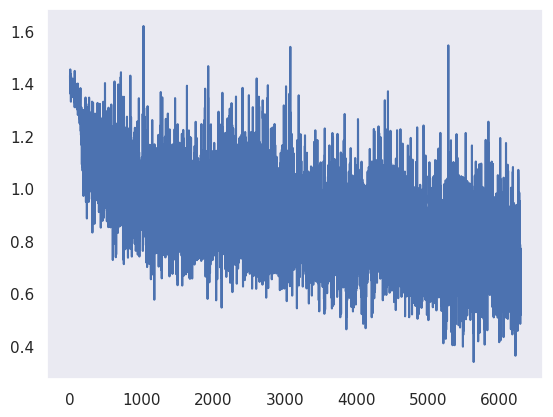

In [25]:
plt.plot(train_losses)

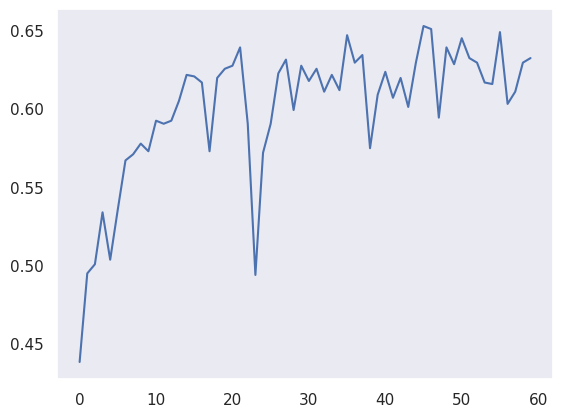

In [26]:
plt.plot(test_accuracy)

In [27]:
metrics2, confusion_matrix2 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics2.compute())
confusion_matrix2.compute()

Correct: 649/1024 (0.6338)
{'acc_detail': tensor([0.7218, 0.5044, 0.6604, 0.6302], device='cuda:0'),
 'acc_unweighted': tensor(0.6292, device='cuda:0'),
 'acc_weighted': tensor(0.6338, device='cuda:0'),
 'f1s': tensor(0.6341, device='cuda:0'),
 'f1s_detail': tensor([0.7245, 0.5361, 0.7246, 0.5512], device='cuda:0'),
 'precision_detail': tensor([0.7273, 0.5721, 0.8028, 0.4897], device='cuda:0'),
 'recall_detail': tensor([0.7218, 0.5044, 0.6604, 0.6302], device='cuda:0'),
 'rocauc': tensor([0.9138, 0.8405, 0.9237, 0.7675], device='cuda:0'),
 'uar': tensor(0.6292, device='cuda:0'),
 'wap': tensor(0.6508, device='cuda:0')}


tensor([[192,   9,   0,  65],
        [ 12, 115,  29,  72],
        [  1,  52, 175,  37],
        [ 59,  25,  14, 167]], device='cuda:0')

In [38]:
model.to("cpu")

M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2OneBlocks(
    (blocks): LSTM(97, 48, batch_first=True)
  )
  (cls_hea

In [39]:
best_epoch = 46
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
best_model = M12(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
pprint(metrics_best.compute())
confusion_matrix_best.compute()

Correct: 669/1024 (0.6533)
{'acc_detail': tensor([0.7556, 0.6535, 0.7509, 0.4528], device='cuda:0'),
 'acc_unweighted': tensor(0.6532, device='cuda:0'),
 'acc_weighted': tensor(0.6533, device='cuda:0'),
 'f1s': tensor(0.6483, device='cuda:0'),
 'f1s_detail': tensor([0.7336, 0.6032, 0.7552, 0.5010], device='cuda:0'),
 'precision_detail': tensor([0.7128, 0.5602, 0.7595, 0.5607], device='cuda:0'),
 'recall_detail': tensor([0.7556, 0.6535, 0.7509, 0.4528], device='cuda:0'),
 'rocauc': tensor([0.9217, 0.8513, 0.9307, 0.7831], device='cuda:0'),
 'uar': tensor(0.6532, device='cuda:0'),
 'wap': tensor(0.6515, device='cuda:0')}


tensor([[201,  16,   0,  49],
        [  8, 149,  39,  32],
        [  0,  53, 199,  13],
        [ 73,  48,  24, 120]], device='cuda:0')

In [40]:
best_model.to('cpu')

M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2OneBlocks(
    (blocks): LSTM(97, 48, batch_first=True)
  )
  (cls_hea

In [28]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 40
# train_losses = []
# test_accuracy = []

optimizer = optim.RAdam(model.parameters(), lr=0.00002)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch3)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch3) as pbar:
    for epoch in range(1+n_epoch+n_epoch2, n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                                                                                                                                                       | 0.014598540145985401/40 [00:00<16:15, 24.40s/it]

Train Epoch: 61 [0/3387 (0%)]	Loss: 0.652863
Mem before-during-after: 19865088 515585024 20923904


  1%|█▍                                                                                                                                                                                       | 0.3065693430656933/40 [00:07<16:34, 25.06s/it]

Train Epoch: 61 [1280/3387 (38%)]	Loss: 0.438694
Mem before-during-after: 20923904 517164032 20923904


  1%|██▊                                                                                                                                                                                       | 0.598540145985401/40 [00:15<16:35, 25.27s/it]

Train Epoch: 61 [2560/3387 (76%)]	Loss: 0.512556
Mem before-during-after: 20923904 517164032 20923904


  3%|████▋                                                                                                                                                                                    | 1.0072992700729917/40 [00:25<15:34, 23.97s/it]


Test Epoch: 61	Accuracy: 669/1024 (65%)

Train Epoch: 62 [0/3387 (0%)]	Loss: 0.706649
Mem before-during-after: 20919808 516639744 20923904


  3%|██████                                                                                                                                                                                   | 1.3065693430656966/40 [00:32<16:27, 25.53s/it]

Train Epoch: 62 [1280/3387 (38%)]	Loss: 0.398570
Mem before-during-after: 20923904 517164032 20923904


  4%|███████▍                                                                                                                                                                                 | 1.5985401459854087/40 [00:40<16:10, 25.27s/it]

Train Epoch: 62 [2560/3387 (76%)]	Loss: 0.681982
Mem before-during-after: 20923904 517164032 20923904


  5%|█████████▎                                                                                                                                                                               | 2.0072992700730055/40 [00:49<15:13, 24.04s/it]


Test Epoch: 62	Accuracy: 654/1024 (64%)

Train Epoch: 63 [0/3387 (0%)]	Loss: 0.758118
Mem before-during-after: 20919808 516639744 20923904


  6%|██████████▋                                                                                                                                                                              | 2.3065693430657013/40 [00:57<15:42, 25.00s/it]

Train Epoch: 63 [1280/3387 (38%)]	Loss: 0.529607
Mem before-during-after: 20923904 517164032 20923904


  6%|████████████                                                                                                                                                                             | 2.5985401459854045/40 [01:04<15:38, 25.10s/it]

Train Epoch: 63 [2560/3387 (76%)]	Loss: 0.771726
Mem before-during-after: 20923904 517164032 20923904


  8%|█████████████▉                                                                                                                                                                            | 3.007299270072989/40 [01:14<14:50, 24.08s/it]


Test Epoch: 63	Accuracy: 665/1024 (65%)

Train Epoch: 64 [0/3387 (0%)]	Loss: 0.637423
Mem before-during-after: 20919808 516639744 20923904


  8%|███████████████▍                                                                                                                                                                          | 3.306569343065685/40 [01:22<15:35, 25.50s/it]

Train Epoch: 64 [1280/3387 (38%)]	Loss: 0.530255
Mem before-during-after: 20923904 517164032 20923904


  9%|████████████████▋                                                                                                                                                                         | 3.598540145985388/40 [01:29<15:26, 25.46s/it]

Train Epoch: 64 [2560/3387 (76%)]	Loss: 0.688478
Mem before-during-after: 20923904 517164032 20923904


 10%|██████████████████▋                                                                                                                                                                       | 4.007299270072973/40 [01:39<14:34, 24.30s/it]


Test Epoch: 64	Accuracy: 657/1024 (64%)

Train Epoch: 65 [0/3387 (0%)]	Loss: 0.885010
Mem before-during-after: 20919808 516639744 20923904


 11%|████████████████████                                                                                                                                                                      | 4.306569343065687/40 [01:47<15:01, 25.27s/it]

Train Epoch: 65 [1280/3387 (38%)]	Loss: 0.600964
Mem before-during-after: 20923904 517164032 20923904


 11%|█████████████████████▍                                                                                                                                                                    | 4.598540145985408/40 [01:54<14:58, 25.39s/it]

Train Epoch: 65 [2560/3387 (76%)]	Loss: 0.624231
Mem before-during-after: 20923904 517164032 20923904


 13%|███████████████████████▎                                                                                                                                                                  | 5.007299270073017/40 [02:04<14:02, 24.07s/it]


Test Epoch: 65	Accuracy: 664/1024 (65%)

Train Epoch: 66 [0/3387 (0%)]	Loss: 0.483574
Mem before-during-after: 20919808 516639744 20923904


 13%|████████████████████████▋                                                                                                                                                                 | 5.306569343065731/40 [02:12<14:39, 25.34s/it]

Train Epoch: 66 [1280/3387 (38%)]	Loss: 1.030581
Mem before-during-after: 20923904 517164032 20923904


 14%|██████████████████████████                                                                                                                                                                | 5.598540145985452/40 [02:19<14:41, 25.62s/it]

Train Epoch: 66 [2560/3387 (76%)]	Loss: 0.577643
Mem before-during-after: 20923904 517164032 20923904


 15%|███████████████████████████▉                                                                                                                                                              | 6.007299270073061/40 [02:29<13:47, 24.35s/it]


Test Epoch: 66	Accuracy: 647/1024 (63%)

Train Epoch: 67 [0/3387 (0%)]	Loss: 0.643223
Mem before-during-after: 20919808 516639744 20923904


 16%|█████████████████████████████▎                                                                                                                                                            | 6.306569343065775/40 [02:37<14:13, 25.32s/it]

Train Epoch: 67 [1280/3387 (38%)]	Loss: 0.566464
Mem before-during-after: 20923904 517164032 20923904


 16%|██████████████████████████████▋                                                                                                                                                           | 6.598540145985496/40 [02:44<14:04, 25.29s/it]

Train Epoch: 67 [2560/3387 (76%)]	Loss: 0.455750
Mem before-during-after: 20923904 517164032 20923904


 18%|████████████████████████████████▌                                                                                                                                                         | 7.007299270073106/40 [02:54<13:20, 24.28s/it]


Test Epoch: 67	Accuracy: 660/1024 (64%)

Train Epoch: 68 [0/3387 (0%)]	Loss: 0.623361
Mem before-during-after: 20919808 516639744 20923904


 18%|██████████████████████████████████▏                                                                                                                                                        | 7.30656934306582/40 [03:02<13:49, 25.36s/it]

Train Epoch: 68 [1280/3387 (38%)]	Loss: 0.678024
Mem before-during-after: 20923904 517164032 20923904


 19%|███████████████████████████████████▎                                                                                                                                                      | 7.598540145985541/40 [03:09<13:34, 25.13s/it]

Train Epoch: 68 [2560/3387 (76%)]	Loss: 0.502542
Mem before-during-after: 20923904 517164032 20923904


 20%|█████████████████████████████████████▍                                                                                                                                                     | 8.00729927007315/40 [03:19<13:10, 24.72s/it]


Test Epoch: 68	Accuracy: 609/1024 (59%)

Train Epoch: 69 [0/3387 (0%)]	Loss: 0.670477
Mem before-during-after: 20919808 516639744 20923904


 21%|██████████████████████████████████████▋                                                                                                                                                   | 8.306569343065863/40 [03:27<13:37, 25.80s/it]

Train Epoch: 69 [1280/3387 (38%)]	Loss: 0.493132
Mem before-during-after: 20923904 517164032 20923904


 21%|███████████████████████████████████████▉                                                                                                                                                  | 8.598540145985584/40 [03:35<13:12, 25.23s/it]

Train Epoch: 69 [2560/3387 (76%)]	Loss: 0.501915
Mem before-during-after: 20923904 517164032 20923904


 23%|█████████████████████████████████████████▉                                                                                                                                                | 9.007299270073194/40 [03:45<12:30, 24.23s/it]


Test Epoch: 69	Accuracy: 665/1024 (65%)

Train Epoch: 70 [0/3387 (0%)]	Loss: 0.443676
Mem before-during-after: 20919808 516639744 20923904


 23%|███████████████████████████████████████████▎                                                                                                                                              | 9.306569343065908/40 [03:52<12:52, 25.17s/it]

Train Epoch: 70 [1280/3387 (38%)]	Loss: 0.530140
Mem before-during-after: 20923904 517164032 20923904


 24%|████████████████████████████████████████████▋                                                                                                                                             | 9.598540145985629/40 [03:59<12:45, 25.19s/it]

Train Epoch: 70 [2560/3387 (76%)]	Loss: 0.751054
Mem before-during-after: 20923904 517164032 20923904


 25%|██████████████████████████████████████████████▎                                                                                                                                          | 10.007299270073238/40 [04:09<12:02, 24.09s/it]


Test Epoch: 70	Accuracy: 655/1024 (64%)

Train Epoch: 71 [0/3387 (0%)]	Loss: 0.520845
Mem before-during-after: 20919808 516639744 20923904


 26%|███████████████████████████████████████████████▋                                                                                                                                         | 10.306569343065952/40 [04:17<12:24, 25.08s/it]

Train Epoch: 71 [1280/3387 (38%)]	Loss: 0.329283
Mem before-during-after: 20923904 517164032 20923904


 26%|█████████████████████████████████████████████████                                                                                                                                        | 10.598540145985673/40 [04:24<12:21, 25.23s/it]

Train Epoch: 71 [2560/3387 (76%)]	Loss: 0.509557
Mem before-during-after: 20923904 517164032 20923904


 28%|██████████████████████████████████████████████████▉                                                                                                                                      | 11.007299270073283/40 [04:34<11:36, 24.02s/it]


Test Epoch: 71	Accuracy: 645/1024 (63%)

Train Epoch: 72 [0/3387 (0%)]	Loss: 0.395002
Mem before-during-after: 20919808 516639744 20923904


 28%|████████████████████████████████████████████████████▎                                                                                                                                    | 11.306569343065997/40 [04:42<12:06, 25.31s/it]

Train Epoch: 72 [1280/3387 (38%)]	Loss: 0.702429
Mem before-during-after: 20923904 517164032 20923904


 29%|█████████████████████████████████████████████████████▋                                                                                                                                   | 11.598540145985718/40 [04:49<11:50, 25.00s/it]

Train Epoch: 72 [2560/3387 (76%)]	Loss: 0.561017
Mem before-during-after: 20923904 517164032 20923904


 30%|███████████████████████████████████████████████████████▌                                                                                                                                 | 12.007299270073327/40 [04:59<11:06, 23.82s/it]


Test Epoch: 72	Accuracy: 646/1024 (63%)

Train Epoch: 73 [0/3387 (0%)]	Loss: 0.676280
Mem before-during-after: 20919808 516639744 20923904


 31%|████████████████████████████████████████████████████████▉                                                                                                                                | 12.306569343066041/40 [05:07<11:34, 25.06s/it]

Train Epoch: 73 [1280/3387 (38%)]	Loss: 0.485049
Mem before-during-after: 20923904 517164032 20923904


 31%|██████████████████████████████████████████████████████████▎                                                                                                                              | 12.598540145985762/40 [05:14<11:25, 25.03s/it]

Train Epoch: 73 [2560/3387 (76%)]	Loss: 0.703620
Mem before-during-after: 20923904 517164032 20923904


 33%|████████████████████████████████████████████████████████████▏                                                                                                                            | 13.007299270073371/40 [05:24<10:43, 23.84s/it]


Test Epoch: 73	Accuracy: 661/1024 (64%)

Train Epoch: 74 [0/3387 (0%)]	Loss: 0.663267
Mem before-during-after: 20919808 516639744 20923904


 33%|█████████████████████████████████████████████████████████████▌                                                                                                                           | 13.306569343066085/40 [05:31<11:08, 25.04s/it]

Train Epoch: 74 [1280/3387 (38%)]	Loss: 0.619025
Mem before-during-after: 20923904 517164032 20923904


 34%|██████████████████████████████████████████████████████████████▉                                                                                                                          | 13.598540145985806/40 [05:39<11:04, 25.15s/it]

Train Epoch: 74 [2560/3387 (76%)]	Loss: 0.417503
Mem before-during-after: 20923904 517164032 20923904


 35%|████████████████████████████████████████████████████████████████▊                                                                                                                        | 14.007299270073416/40 [05:49<10:17, 23.78s/it]


Test Epoch: 74	Accuracy: 648/1024 (63%)

Train Epoch: 75 [0/3387 (0%)]	Loss: 0.603995
Mem before-during-after: 20919808 516639744 20923904


 36%|██████████████████████████████████████████████████████████████████▌                                                                                                                       | 14.30656934306613/40 [05:56<10:40, 24.93s/it]

Train Epoch: 75 [1280/3387 (38%)]	Loss: 0.542105
Mem before-during-after: 20923904 517164032 20923904


 36%|███████████████████████████████████████████████████████████████████▉                                                                                                                      | 14.59854014598585/40 [06:03<10:58, 25.91s/it]

Train Epoch: 75 [2560/3387 (76%)]	Loss: 0.345991
Mem before-during-after: 20923904 517164032 20923904


 38%|█████████████████████████████████████████████████████████████████████▊                                                                                                                    | 15.00729927007346/40 [06:13<09:56, 23.85s/it]


Test Epoch: 75	Accuracy: 665/1024 (65%)

Train Epoch: 76 [0/3387 (0%)]	Loss: 0.494635
Mem before-during-after: 20919808 516639744 20923904


 38%|██████████████████████████████████████████████████████████████████████▊                                                                                                                  | 15.306569343066174/40 [06:21<10:17, 25.02s/it]

Train Epoch: 76 [1280/3387 (38%)]	Loss: 0.440850
Mem before-during-after: 20923904 517164032 20923904


 39%|████████████████████████████████████████████████████████████████████████▏                                                                                                                | 15.598540145985895/40 [06:28<10:26, 25.69s/it]

Train Epoch: 76 [2560/3387 (76%)]	Loss: 0.796861
Mem before-during-after: 20923904 517164032 20923904


 40%|██████████████████████████████████████████████████████████████████████████                                                                                                               | 16.007299270073503/40 [06:38<09:35, 23.98s/it]


Test Epoch: 76	Accuracy: 657/1024 (64%)

Train Epoch: 77 [0/3387 (0%)]	Loss: 0.483430
Mem before-during-after: 20919808 516639744 20923904


 41%|███████████████████████████████████████████████████████████████████████████▍                                                                                                             | 16.306569343066144/40 [06:46<09:50, 24.91s/it]

Train Epoch: 77 [1280/3387 (38%)]	Loss: 0.716997
Mem before-during-after: 20923904 517164032 20923904


 41%|████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 16.598540145985794/40 [06:53<09:45, 25.00s/it]

Train Epoch: 77 [2560/3387 (76%)]	Loss: 0.433532
Mem before-during-after: 20923904 517164032 20923904


 43%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 17.007299270073304/40 [07:03<09:10, 23.96s/it]


Test Epoch: 77	Accuracy: 665/1024 (65%)

Train Epoch: 78 [0/3387 (0%)]	Loss: 0.420318
Mem before-during-after: 20919808 516639744 20923904


 43%|████████████████████████████████████████████████████████████████████████████████                                                                                                         | 17.306569343065945/40 [07:10<09:29, 25.09s/it]

Train Epoch: 78 [1280/3387 (38%)]	Loss: 0.701893
Mem before-during-after: 20923904 517164032 20923904


 44%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 17.598540145985595/40 [07:18<09:18, 24.91s/it]

Train Epoch: 78 [2560/3387 (76%)]	Loss: 0.609089
Mem before-during-after: 20923904 517164032 20923904


 45%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 18.007299270073105/40 [07:28<08:43, 23.81s/it]


Test Epoch: 78	Accuracy: 643/1024 (63%)

Train Epoch: 79 [0/3387 (0%)]	Loss: 0.344549
Mem before-during-after: 20919808 516639744 20923904


 46%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 18.306569343065746/40 [07:35<09:03, 25.07s/it]

Train Epoch: 79 [1280/3387 (38%)]	Loss: 0.497178
Mem before-during-after: 20923904 517164032 20923904


 46%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 18.598540145985396/40 [07:42<08:56, 25.09s/it]

Train Epoch: 79 [2560/3387 (76%)]	Loss: 0.739921
Mem before-during-after: 20923904 517164032 20923904


 48%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 19.007299270072906/40 [07:52<08:31, 24.36s/it]


Test Epoch: 79	Accuracy: 650/1024 (63%)

Train Epoch: 80 [0/3387 (0%)]	Loss: 0.542925
Mem before-during-after: 20919808 516639744 20923904


 48%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 19.306569343065547/40 [08:00<08:37, 25.02s/it]

Train Epoch: 80 [1280/3387 (38%)]	Loss: 0.777619
Mem before-during-after: 20923904 517164032 20923904


 49%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 19.598540145985197/40 [08:07<08:28, 24.91s/it]

Train Epoch: 80 [2560/3387 (76%)]	Loss: 0.704631
Mem before-during-after: 20923904 517164032 20923904


 50%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 20.007299270072707/40 [08:17<07:55, 23.80s/it]


Test Epoch: 80	Accuracy: 657/1024 (64%)

Train Epoch: 81 [0/3387 (0%)]	Loss: 0.672702
Mem before-during-after: 20919808 516639744 20923904


 51%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 20.306569343065348/40 [08:25<08:19, 25.36s/it]

Train Epoch: 81 [1280/3387 (38%)]	Loss: 0.720344
Mem before-during-after: 20923904 517164032 20923904


 51%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 20.598540145984998/40 [08:32<08:12, 25.37s/it]

Train Epoch: 81 [2560/3387 (76%)]	Loss: 0.395756
Mem before-during-after: 20923904 517164032 20923904


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 21.007299270072508/40 [08:42<07:33, 23.87s/it]


Test Epoch: 81	Accuracy: 643/1024 (63%)

Train Epoch: 82 [0/3387 (0%)]	Loss: 0.397876
Mem before-during-after: 20919808 516639744 20923904


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 21.30656934306515/40 [08:49<07:47, 25.03s/it]

Train Epoch: 82 [1280/3387 (38%)]	Loss: 0.535309
Mem before-during-after: 20923904 517164032 20923904


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 21.5985401459848/40 [08:57<07:51, 25.61s/it]

Train Epoch: 82 [2560/3387 (76%)]	Loss: 0.501820
Mem before-during-after: 20923904 517164032 20923904


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 22.00729927007231/40 [09:06<07:08, 23.80s/it]


Test Epoch: 82	Accuracy: 645/1024 (63%)

Train Epoch: 83 [0/3387 (0%)]	Loss: 0.570787
Mem before-during-after: 20919808 516639744 20923904


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 22.30656934306495/40 [09:14<07:22, 25.03s/it]

Train Epoch: 83 [1280/3387 (38%)]	Loss: 0.586577
Mem before-during-after: 20923904 517164032 20923904


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 22.5985401459846/40 [09:21<07:16, 25.06s/it]

Train Epoch: 83 [2560/3387 (76%)]	Loss: 0.701823
Mem before-during-after: 20923904 517164032 20923904


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 23.00729927007211/40 [09:31<06:48, 24.01s/it]


Test Epoch: 83	Accuracy: 623/1024 (61%)

Train Epoch: 84 [0/3387 (0%)]	Loss: 0.400441
Mem before-during-after: 20919808 516639744 20923904


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 23.30656934306475/40 [09:39<06:56, 24.95s/it]

Train Epoch: 84 [1280/3387 (38%)]	Loss: 0.715963
Mem before-during-after: 20923904 517164032 20923904


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 23.5985401459844/40 [09:46<06:50, 25.02s/it]

Train Epoch: 84 [2560/3387 (76%)]	Loss: 0.627753
Mem before-during-after: 20923904 517164032 20923904


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 24.00729927007191/40 [09:56<06:30, 24.45s/it]


Test Epoch: 84	Accuracy: 626/1024 (61%)

Train Epoch: 85 [0/3387 (0%)]	Loss: 0.666097
Mem before-during-after: 20919808 516639744 20923904


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 24.306569343064552/40 [10:04<06:42, 25.66s/it]

Train Epoch: 85 [1280/3387 (38%)]	Loss: 0.451722
Mem before-during-after: 20923904 517164032 20923904


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 24.598540145984202/40 [10:11<06:34, 25.59s/it]

Train Epoch: 85 [2560/3387 (76%)]	Loss: 0.384945
Mem before-during-after: 20923904 517164032 20923904


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 25.007299270071712/40 [10:21<06:08, 24.59s/it]


Test Epoch: 85	Accuracy: 628/1024 (61%)

Train Epoch: 86 [0/3387 (0%)]	Loss: 0.849830
Mem before-during-after: 20919808 516639744 20923904


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 25.306569343064353/40 [10:29<06:15, 25.57s/it]

Train Epoch: 86 [1280/3387 (38%)]	Loss: 0.542389
Mem before-during-after: 20923904 517164032 20923904


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 25.598540145984003/40 [10:37<06:08, 25.59s/it]

Train Epoch: 86 [2560/3387 (76%)]	Loss: 0.583202
Mem before-during-after: 20923904 517164032 20923904


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 26.007299270071513/40 [10:47<05:43, 24.54s/it]


Test Epoch: 86	Accuracy: 648/1024 (63%)

Train Epoch: 87 [0/3387 (0%)]	Loss: 0.564340
Mem before-during-after: 20919808 516639744 20923904


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 26.306569343064155/40 [10:54<05:49, 25.52s/it]

Train Epoch: 87 [1280/3387 (38%)]	Loss: 0.764394
Mem before-during-after: 20923904 517164032 20923904


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 26.598540145983804/40 [11:02<05:42, 25.54s/it]

Train Epoch: 87 [2560/3387 (76%)]	Loss: 0.521282
Mem before-during-after: 20923904 517164032 20923904


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 27.007299270071314/40 [11:12<05:09, 23.83s/it]


Test Epoch: 87	Accuracy: 640/1024 (62%)

Train Epoch: 88 [0/3387 (0%)]	Loss: 0.911252
Mem before-during-after: 20919808 516639744 20923904


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 27.306569343063956/40 [11:19<05:27, 25.80s/it]

Train Epoch: 88 [1280/3387 (38%)]	Loss: 0.724528
Mem before-during-after: 20923904 517164032 20923904


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 27.598540145983605/40 [11:27<05:16, 25.49s/it]

Train Epoch: 88 [2560/3387 (76%)]	Loss: 0.391755
Mem before-during-after: 20923904 517164032 20923904


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 28.007299270071115/40 [11:37<04:45, 23.81s/it]


Test Epoch: 88	Accuracy: 636/1024 (62%)

Train Epoch: 89 [0/3387 (0%)]	Loss: 0.719857
Mem before-during-after: 20919808 516639744 20923904


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 28.306569343063757/40 [11:44<04:51, 24.96s/it]

Train Epoch: 89 [1280/3387 (38%)]	Loss: 0.685407
Mem before-during-after: 20923904 517164032 20923904


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 28.598540145983407/40 [11:52<04:53, 25.75s/it]

Train Epoch: 89 [2560/3387 (76%)]	Loss: 0.517348
Mem before-during-after: 20923904 517164032 20923904


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 29.007299270070916/40 [12:02<04:23, 23.99s/it]


Test Epoch: 89	Accuracy: 650/1024 (63%)

Train Epoch: 90 [0/3387 (0%)]	Loss: 0.398253
Mem before-during-after: 20919808 516639744 20923904


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 29.306569343063558/40 [12:09<04:30, 25.33s/it]

Train Epoch: 90 [1280/3387 (38%)]	Loss: 0.979112
Mem before-during-after: 20923904 517164032 20923904


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 29.598540145983208/40 [12:16<04:19, 24.99s/it]

Train Epoch: 90 [2560/3387 (76%)]	Loss: 0.527497
Mem before-during-after: 20923904 517164032 20923904


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 30.007299270070718/40 [12:26<04:01, 24.16s/it]


Test Epoch: 90	Accuracy: 642/1024 (63%)

Train Epoch: 91 [0/3387 (0%)]	Loss: 0.480105
Mem before-during-after: 20919808 516639744 20923904


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 30.30656934306336/40 [12:34<04:01, 24.92s/it]

Train Epoch: 91 [1280/3387 (38%)]	Loss: 0.454564
Mem before-during-after: 20923904 517164032 20923904


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 30.59854014598301/40 [12:41<03:55, 25.07s/it]

Train Epoch: 91 [2560/3387 (76%)]	Loss: 0.425365
Mem before-during-after: 20923904 517164032 20923904


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 31.00729927007052/40 [12:51<03:36, 24.10s/it]


Test Epoch: 91	Accuracy: 638/1024 (62%)

Train Epoch: 92 [0/3387 (0%)]	Loss: 0.317929
Mem before-during-after: 20919808 516639744 20923904


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 31.30656934306316/40 [12:59<03:36, 24.90s/it]

Train Epoch: 92 [1280/3387 (38%)]	Loss: 0.390393
Mem before-during-after: 20923904 517164032 20923904


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 31.59854014598281/40 [13:06<03:29, 24.99s/it]

Train Epoch: 92 [2560/3387 (76%)]	Loss: 0.751562
Mem before-during-after: 20923904 517164032 20923904


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 32.00729927007032/40 [13:16<03:11, 23.92s/it]


Test Epoch: 92	Accuracy: 648/1024 (63%)

Train Epoch: 93 [0/3387 (0%)]	Loss: 0.436109
Mem before-during-after: 20919808 516639744 20923904


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 32.30656934306296/40 [13:23<03:14, 25.34s/it]

Train Epoch: 93 [1280/3387 (38%)]	Loss: 0.372088
Mem before-during-after: 20923904 517164032 20923904


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 32.59854014598261/40 [13:31<03:06, 25.13s/it]

Train Epoch: 93 [2560/3387 (76%)]	Loss: 0.600095
Mem before-during-after: 20923904 517164032 20923904


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 33.00729927007012/40 [13:41<02:46, 23.84s/it]


Test Epoch: 93	Accuracy: 638/1024 (62%)

Train Epoch: 94 [0/3387 (0%)]	Loss: 0.707880
Mem before-during-after: 20919808 516639744 20923904


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 33.30656934306276/40 [13:48<02:48, 25.14s/it]

Train Epoch: 94 [1280/3387 (38%)]	Loss: 0.637486
Mem before-during-after: 20923904 517164032 20923904


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 33.59854014598241/40 [13:55<02:40, 25.00s/it]

Train Epoch: 94 [2560/3387 (76%)]	Loss: 0.549690
Mem before-during-after: 20923904 517164032 20923904


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 34.00729927006992/40 [14:05<02:22, 23.80s/it]


Test Epoch: 94	Accuracy: 644/1024 (63%)

Train Epoch: 95 [0/3387 (0%)]	Loss: 0.650817
Mem before-during-after: 20919808 516639744 20923904


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 34.30656934306256/40 [14:13<02:24, 25.38s/it]

Train Epoch: 95 [1280/3387 (38%)]	Loss: 0.284326
Mem before-during-after: 20923904 517164032 20923904


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 34.59854014598221/40 [14:20<02:14, 24.91s/it]

Train Epoch: 95 [2560/3387 (76%)]	Loss: 0.379658
Mem before-during-after: 20923904 517164032 20923904


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 35.00729927006972/40 [14:30<01:58, 23.78s/it]


Test Epoch: 95	Accuracy: 625/1024 (61%)

Train Epoch: 96 [0/3387 (0%)]	Loss: 0.580937
Mem before-during-after: 20919808 516639744 20923904


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 35.306569343062364/40 [14:38<01:56, 24.91s/it]

Train Epoch: 96 [1280/3387 (38%)]	Loss: 0.677826
Mem before-during-after: 20923904 517164032 20923904


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 35.598540145982014/40 [14:45<01:50, 25.16s/it]

Train Epoch: 96 [2560/3387 (76%)]	Loss: 0.333664
Mem before-during-after: 20923904 517164032 20923904


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 36.007299270069524/40 [14:55<01:35, 23.87s/it]


Test Epoch: 96	Accuracy: 601/1024 (59%)

Train Epoch: 97 [0/3387 (0%)]	Loss: 0.808406
Mem before-during-after: 20919808 516639744 20923904


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 36.306569343062165/40 [15:02<01:32, 25.11s/it]

Train Epoch: 97 [1280/3387 (38%)]	Loss: 0.368940
Mem before-during-after: 20923904 517164032 20923904


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 36.598540145981815/40 [15:10<01:25, 25.04s/it]

Train Epoch: 97 [2560/3387 (76%)]	Loss: 0.276631
Mem before-during-after: 20923904 517164032 20923904


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 37.007299270069325/40 [15:20<01:12, 24.17s/it]


Test Epoch: 97	Accuracy: 641/1024 (63%)

Train Epoch: 98 [0/3387 (0%)]	Loss: 0.701847
Mem before-during-after: 20919808 516639744 20923904


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 37.306569343061966/40 [15:27<01:06, 24.87s/it]

Train Epoch: 98 [1280/3387 (38%)]	Loss: 0.318580
Mem before-during-after: 20923904 517164032 20923904


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 37.598540145981616/40 [15:34<01:00, 25.02s/it]

Train Epoch: 98 [2560/3387 (76%)]	Loss: 0.662959
Mem before-during-after: 20923904 517164032 20923904


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 38.007299270069126/40 [15:44<00:48, 24.23s/it]


Test Epoch: 98	Accuracy: 628/1024 (61%)

Train Epoch: 99 [0/3387 (0%)]	Loss: 0.478731
Mem before-during-after: 20919808 516639744 20923904


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 38.30656934306177/40 [15:52<00:42, 25.09s/it]

Train Epoch: 99 [1280/3387 (38%)]	Loss: 0.400210
Mem before-during-after: 20923904 517164032 20923904


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 38.59854014598142/40 [15:59<00:34, 24.91s/it]

Train Epoch: 99 [2560/3387 (76%)]	Loss: 0.311783
Mem before-during-after: 20923904 517164032 20923904


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 39.00729927006893/40 [16:09<00:23, 23.90s/it]


Test Epoch: 99	Accuracy: 656/1024 (64%)

Train Epoch: 100 [0/3387 (0%)]	Loss: 0.282880
Mem before-during-after: 20919808 516639744 20923904


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 39.30656934306157/40 [16:17<00:17, 25.21s/it]

Train Epoch: 100 [1280/3387 (38%)]	Loss: 0.491247
Mem before-during-after: 20923904 517164032 20923904


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 39.59854014598122/40 [16:24<00:10, 25.69s/it]

Train Epoch: 100 [2560/3387 (76%)]	Loss: 0.580301
Mem before-during-after: 20923904 517164032 20923904


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 39.99999999999574/40 [16:34<00:00, 24.86s/it]


Test Epoch: 100	Accuracy: 624/1024 (61%)



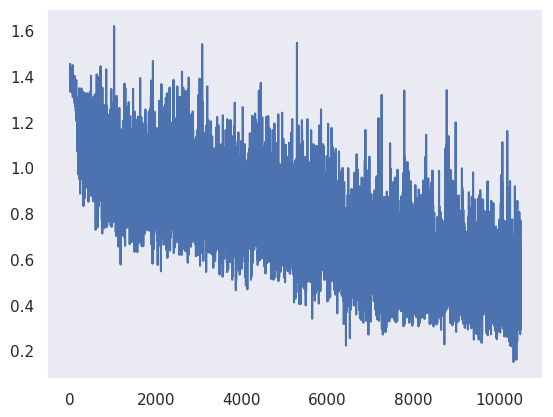

In [29]:
plt.plot(train_losses)

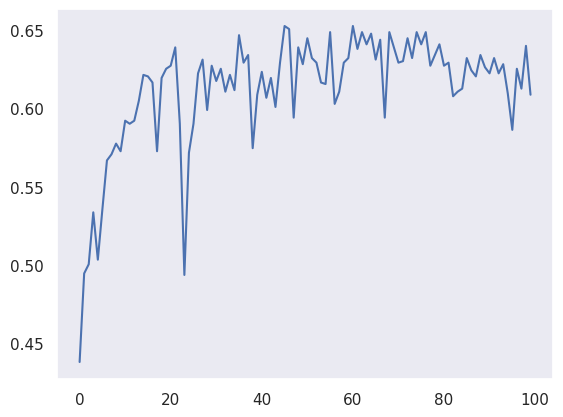

In [30]:
plt.plot(test_accuracy)

In [31]:
metrics3, confusion_matrix3 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics3.compute())
confusion_matrix3.compute()

Correct: 624/1024 (0.6094)
{'acc_detail': tensor([0.6692, 0.4649, 0.8788, 0.4060], device='cuda:0'),
 'acc_unweighted': tensor(0.6047, device='cuda:0'),
 'acc_weighted': tensor(0.6094, device='cuda:0'),
 'f1s': tensor(0.5946, device='cuda:0'),
 'f1s_detail': tensor([0.7050, 0.4988, 0.6915, 0.4832], device='cuda:0'),
 'precision_detail': tensor([0.7448, 0.5381, 0.5700, 0.5967], device='cuda:0'),
 'recall_detail': tensor([0.6692, 0.4649, 0.8788, 0.4060], device='cuda:0'),
 'rocauc': tensor([0.9040, 0.8275, 0.9168, 0.7655], device='cuda:0'),
 'uar': tensor(0.6047, device='cuda:0'),
 'wap': tensor(0.6152, device='cuda:0')}


tensor([[178,  24,   9,  55],
        [ 10, 106, 101,  11],
        [  0,  25, 232,   7],
        [ 51,  42,  65, 108]], device='cuda:0')

In [32]:
np.save('../cremad4_m12new_trill19_100epochs_train_losses.npy', train_losses, allow_pickle=True)
np.save('../cremad4_m12new_trill19_100epochs_test_accuracy.npy', test_accuracy, allow_pickle=True)

In [33]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 40
n_epoch4 = 50
# train_losses = []
# test_accuracy = []

optimizer = optim.RAdam(model.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.005,
    steps_per_epoch=len(train_loader), epochs=n_epoch4)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch4) as pbar:
    for epoch in range(1+100, n_epoch4+100 + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                                                                                                                                                       | 0.014598540145985401/50 [00:00<21:15, 25.51s/it]

Train Epoch: 101 [0/3387 (0%)]	Loss: 0.595069
Mem before-during-after: 19920384 515640320 20979200


  1%|█▏                                                                                                                                                                                       | 0.3065693430656933/50 [00:08<21:34, 26.05s/it]

Train Epoch: 101 [1280/3387 (38%)]	Loss: 0.338182
Mem before-during-after: 20979200 517219328 20979200


  1%|██▏                                                                                                                                                                                       | 0.598540145985401/50 [00:15<21:22, 25.97s/it]

Train Epoch: 101 [2560/3387 (76%)]	Loss: 0.312097
Mem before-during-after: 20979200 517219328 20979200


  2%|███▋                                                                                                                                                                                     | 1.0072992700729917/50 [00:26<20:25, 25.02s/it]


Test Epoch: 101	Accuracy: 648/1024 (63%)

Train Epoch: 102 [0/3387 (0%)]	Loss: 0.224794
Mem before-during-after: 20975104 516695040 20979200


  3%|████▊                                                                                                                                                                                    | 1.3065693430656966/50 [00:33<21:05, 25.98s/it]

Train Epoch: 102 [1280/3387 (38%)]	Loss: 0.308579
Mem before-during-after: 20979200 517219328 20979200


  3%|█████▉                                                                                                                                                                                   | 1.5985401459854087/50 [00:41<21:13, 26.31s/it]

Train Epoch: 102 [2560/3387 (76%)]	Loss: 0.768203
Mem before-during-after: 20979200 517219328 20979200


  4%|███████▍                                                                                                                                                                                 | 2.0072992700730055/50 [00:51<19:56, 24.94s/it]


Test Epoch: 102	Accuracy: 652/1024 (64%)

Train Epoch: 103 [0/3387 (0%)]	Loss: 0.287780
Mem before-during-after: 20975104 516695040 20979200


  5%|████████▌                                                                                                                                                                                | 2.3065693430657013/50 [00:59<20:37, 25.95s/it]

Train Epoch: 103 [1280/3387 (38%)]	Loss: 0.252891
Mem before-during-after: 20979200 517219328 20979200


  5%|█████████▌                                                                                                                                                                               | 2.5985401459854045/50 [01:07<20:41, 26.19s/it]

Train Epoch: 103 [2560/3387 (76%)]	Loss: 0.195268
Mem before-during-after: 20979200 517219328 20979200


  6%|███████████▏                                                                                                                                                                              | 3.007299270072989/50 [01:17<20:00, 25.55s/it]


Test Epoch: 103	Accuracy: 653/1024 (64%)

Train Epoch: 104 [0/3387 (0%)]	Loss: 0.246849
Mem before-during-after: 20975104 516695040 20979200


  7%|████████████▎                                                                                                                                                                             | 3.306569343065685/50 [01:25<20:20, 26.14s/it]

Train Epoch: 104 [1280/3387 (38%)]	Loss: 0.308522
Mem before-during-after: 20979200 517219328 20979200


  7%|█████████████▍                                                                                                                                                                            | 3.598540145985388/50 [01:32<19:59, 25.85s/it]

Train Epoch: 104 [2560/3387 (76%)]	Loss: 0.251300
Mem before-during-after: 20979200 517219328 20979200


  8%|██████████████▉                                                                                                                                                                           | 4.007299270072973/50 [01:43<19:01, 24.81s/it]


Test Epoch: 104	Accuracy: 645/1024 (63%)

Train Epoch: 105 [0/3387 (0%)]	Loss: 0.358335
Mem before-during-after: 20975104 516695040 20979200


  9%|███████████████▉                                                                                                                                                                          | 4.299270072992694/50 [01:50<20:17, 26.65s/it]

Train Epoch: 105 [1280/3387 (38%)]	Loss: 0.251150
Mem before-during-after: 20979200 517219328 20979200


  9%|█████████████████                                                                                                                                                                         | 4.598540145985408/50 [01:58<19:06, 25.26s/it]

Train Epoch: 105 [2560/3387 (76%)]	Loss: 0.269583
Mem before-during-after: 20979200 517219328 20979200


 10%|██████████████████▋                                                                                                                                                                       | 5.007299270073017/50 [02:08<18:35, 24.78s/it]


Test Epoch: 105	Accuracy: 643/1024 (63%)

Train Epoch: 106 [0/3387 (0%)]	Loss: 0.354228
Mem before-during-after: 20975104 516695040 20979200


 11%|███████████████████▋                                                                                                                                                                      | 5.306569343065731/50 [02:16<18:47, 25.22s/it]

Train Epoch: 106 [1280/3387 (38%)]	Loss: 0.286921
Mem before-during-after: 20979200 517219328 20979200


 11%|████████████████████▊                                                                                                                                                                     | 5.598540145985452/50 [02:23<18:37, 25.16s/it]

Train Epoch: 106 [2560/3387 (76%)]	Loss: 0.425792
Mem before-during-after: 20979200 517219328 20979200


 12%|██████████████████████▎                                                                                                                                                                   | 6.007299270073061/50 [02:33<17:46, 24.25s/it]


Test Epoch: 106	Accuracy: 633/1024 (62%)

Train Epoch: 107 [0/3387 (0%)]	Loss: 0.253376
Mem before-during-after: 20975104 516695040 20979200


 13%|███████████████████████▍                                                                                                                                                                  | 6.306569343065775/50 [02:41<18:21, 25.22s/it]

Train Epoch: 107 [1280/3387 (38%)]	Loss: 0.445921
Mem before-during-after: 20979200 517219328 20979200


 13%|████████████████████████▌                                                                                                                                                                 | 6.598540145985496/50 [02:48<18:21, 25.38s/it]

Train Epoch: 107 [2560/3387 (76%)]	Loss: 0.219136
Mem before-during-after: 20979200 517219328 20979200


 14%|██████████████████████████                                                                                                                                                                | 7.007299270073106/50 [02:58<17:23, 24.28s/it]


Test Epoch: 107	Accuracy: 636/1024 (62%)

Train Epoch: 108 [0/3387 (0%)]	Loss: 0.218074
Mem before-during-after: 20975104 516695040 20979200


 15%|███████████████████████████▎                                                                                                                                                               | 7.30656934306582/50 [03:06<18:04, 25.39s/it]

Train Epoch: 108 [1280/3387 (38%)]	Loss: 0.186562
Mem before-during-after: 20979200 517219328 20979200


 15%|████████████████████████████▎                                                                                                                                                             | 7.598540145985541/50 [03:13<18:06, 25.61s/it]

Train Epoch: 108 [2560/3387 (76%)]	Loss: 0.319400
Mem before-during-after: 20979200 517219328 20979200


 16%|█████████████████████████████▉                                                                                                                                                             | 8.00729927007315/50 [03:24<17:16, 24.67s/it]


Test Epoch: 108	Accuracy: 635/1024 (62%)

Train Epoch: 109 [0/3387 (0%)]	Loss: 0.163753
Mem before-during-after: 20975104 516695040 20979200


 17%|██████████████████████████████▉                                                                                                                                                           | 8.306569343065863/50 [03:31<17:55, 25.79s/it]

Train Epoch: 109 [1280/3387 (38%)]	Loss: 0.313865
Mem before-during-after: 20979200 517219328 20979200


 17%|███████████████████████████████▉                                                                                                                                                          | 8.598540145985584/50 [03:39<17:41, 25.64s/it]

Train Epoch: 109 [2560/3387 (76%)]	Loss: 0.372343
Mem before-during-after: 20979200 517219328 20979200


 18%|█████████████████████████████████▌                                                                                                                                                        | 9.007299270073194/50 [03:49<16:54, 24.74s/it]


Test Epoch: 109	Accuracy: 654/1024 (64%)

Train Epoch: 110 [0/3387 (0%)]	Loss: 0.350276
Mem before-during-after: 20975104 516695040 20979200


 19%|██████████████████████████████████▌                                                                                                                                                       | 9.306569343065908/50 [03:57<17:20, 25.58s/it]

Train Epoch: 110 [1280/3387 (38%)]	Loss: 0.229400
Mem before-during-after: 20979200 517219328 20979200


 19%|███████████████████████████████████▋                                                                                                                                                      | 9.598540145985629/50 [04:04<17:14, 25.60s/it]

Train Epoch: 110 [2560/3387 (76%)]	Loss: 0.213374
Mem before-during-after: 20979200 517219328 20979200


 20%|█████████████████████████████████████                                                                                                                                                    | 10.007299270073238/50 [04:15<16:24, 24.61s/it]


Test Epoch: 110	Accuracy: 656/1024 (64%)

Train Epoch: 111 [0/3387 (0%)]	Loss: 0.243012
Mem before-during-after: 20975104 516695040 20979200


 21%|██████████████████████████████████████▏                                                                                                                                                  | 10.306569343065952/50 [04:22<16:57, 25.63s/it]

Train Epoch: 111 [1280/3387 (38%)]	Loss: 0.233955
Mem before-during-after: 20979200 517219328 20979200


 21%|███████████████████████████████████████▏                                                                                                                                                 | 10.598540145985673/50 [04:30<16:48, 25.60s/it]

Train Epoch: 111 [2560/3387 (76%)]	Loss: 0.337921
Mem before-during-after: 20979200 517219328 20979200


 22%|████████████████████████████████████████▋                                                                                                                                                | 11.007299270073283/50 [04:40<15:52, 24.42s/it]


Test Epoch: 111	Accuracy: 633/1024 (62%)

Train Epoch: 112 [0/3387 (0%)]	Loss: 0.311821
Mem before-during-after: 20975104 516695040 20979200


 23%|█████████████████████████████████████████▊                                                                                                                                               | 11.306569343065997/50 [04:47<16:15, 25.22s/it]

Train Epoch: 112 [1280/3387 (38%)]	Loss: 0.194600
Mem before-during-after: 20979200 517219328 20979200


 23%|██████████████████████████████████████████▉                                                                                                                                              | 11.598540145985718/50 [04:55<16:11, 25.30s/it]

Train Epoch: 112 [2560/3387 (76%)]	Loss: 0.504768
Mem before-during-after: 20979200 517219328 20979200


 24%|████████████████████████████████████████████▍                                                                                                                                            | 12.007299270073327/50 [05:05<15:23, 24.31s/it]


Test Epoch: 112	Accuracy: 648/1024 (63%)

Train Epoch: 113 [0/3387 (0%)]	Loss: 0.291459
Mem before-during-after: 20975104 516695040 20979200


 25%|█████████████████████████████████████████████▌                                                                                                                                           | 12.306569343066041/50 [05:12<15:50, 25.23s/it]

Train Epoch: 113 [1280/3387 (38%)]	Loss: 0.259791
Mem before-during-after: 20979200 517219328 20979200


 25%|██████████████████████████████████████████████▌                                                                                                                                          | 12.598540145985762/50 [05:20<15:41, 25.17s/it]

Train Epoch: 113 [2560/3387 (76%)]	Loss: 0.214116
Mem before-during-after: 20979200 517219328 20979200


 26%|████████████████████████████████████████████████▏                                                                                                                                        | 13.007299270073371/50 [05:30<14:56, 24.25s/it]


Test Epoch: 113	Accuracy: 643/1024 (63%)

Train Epoch: 114 [0/3387 (0%)]	Loss: 0.233919
Mem before-during-after: 20975104 516695040 20979200


 27%|█████████████████████████████████████████████████▏                                                                                                                                       | 13.306569343066085/50 [05:37<15:28, 25.30s/it]

Train Epoch: 114 [1280/3387 (38%)]	Loss: 0.230212
Mem before-during-after: 20979200 517219328 20979200


 27%|██████████████████████████████████████████████████▎                                                                                                                                      | 13.598540145985806/50 [05:45<15:15, 25.16s/it]

Train Epoch: 114 [2560/3387 (76%)]	Loss: 0.241876
Mem before-during-after: 20979200 517219328 20979200


 28%|███████████████████████████████████████████████████▊                                                                                                                                     | 14.007299270073416/50 [05:55<14:32, 24.23s/it]


Test Epoch: 114	Accuracy: 638/1024 (62%)

Train Epoch: 115 [0/3387 (0%)]	Loss: 0.250358
Mem before-during-after: 20975104 516695040 20979200


 29%|█████████████████████████████████████████████████████▏                                                                                                                                    | 14.30656934306613/50 [06:02<15:01, 25.26s/it]

Train Epoch: 115 [1280/3387 (38%)]	Loss: 0.298869
Mem before-during-after: 20979200 517219328 20979200


 29%|██████████████████████████████████████████████████████▎                                                                                                                                   | 14.59854014598585/50 [06:10<14:51, 25.19s/it]

Train Epoch: 115 [2560/3387 (76%)]	Loss: 0.181862
Mem before-during-after: 20979200 517219328 20979200


 30%|███████████████████████████████████████████████████████▊                                                                                                                                  | 15.00729927007346/50 [06:20<14:22, 24.64s/it]


Test Epoch: 115	Accuracy: 649/1024 (63%)

Train Epoch: 116 [0/3387 (0%)]	Loss: 0.379257
Mem before-during-after: 20975104 516695040 20979200


 31%|████████████████████████████████████████████████████████▋                                                                                                                                | 15.306569343066174/50 [06:27<14:31, 25.13s/it]

Train Epoch: 116 [1280/3387 (38%)]	Loss: 0.142945
Mem before-during-after: 20979200 517219328 20979200


 31%|█████████████████████████████████████████████████████████▋                                                                                                                               | 15.598540145985895/50 [06:35<14:29, 25.28s/it]

Train Epoch: 116 [2560/3387 (76%)]	Loss: 0.300745
Mem before-during-after: 20979200 517219328 20979200


 32%|███████████████████████████████████████████████████████████▏                                                                                                                             | 16.007299270073503/50 [06:45<13:50, 24.45s/it]


Test Epoch: 116	Accuracy: 649/1024 (63%)

Train Epoch: 117 [0/3387 (0%)]	Loss: 0.178770
Mem before-during-after: 20975104 516695040 20979200


 33%|████████████████████████████████████████████████████████████▎                                                                                                                            | 16.306569343066144/50 [06:52<14:07, 25.16s/it]

Train Epoch: 117 [1280/3387 (38%)]	Loss: 0.265693
Mem before-during-after: 20979200 517219328 20979200


 33%|█████████████████████████████████████████████████████████████▍                                                                                                                           | 16.598540145985794/50 [07:00<14:02, 25.22s/it]

Train Epoch: 117 [2560/3387 (76%)]	Loss: 0.209111
Mem before-during-after: 20979200 517219328 20979200


 34%|██████████████████████████████████████████████████████████████▉                                                                                                                          | 17.007299270073304/50 [07:10<13:18, 24.19s/it]


Test Epoch: 117	Accuracy: 645/1024 (63%)

Train Epoch: 118 [0/3387 (0%)]	Loss: 0.271793
Mem before-during-after: 20975104 516695040 20979200


 35%|████████████████████████████████████████████████████████████████                                                                                                                         | 17.306569343065945/50 [07:17<13:46, 25.27s/it]

Train Epoch: 118 [1280/3387 (38%)]	Loss: 0.373210
Mem before-during-after: 20979200 517219328 20979200


 35%|█████████████████████████████████████████████████████████████████                                                                                                                        | 17.598540145985595/50 [07:25<13:36, 25.20s/it]

Train Epoch: 118 [2560/3387 (76%)]	Loss: 0.166621
Mem before-during-after: 20979200 517219328 20979200


 36%|██████████████████████████████████████████████████████████████████▋                                                                                                                      | 18.007299270073105/50 [07:35<12:54, 24.20s/it]


Test Epoch: 118	Accuracy: 654/1024 (64%)

Train Epoch: 119 [0/3387 (0%)]	Loss: 0.266666
Mem before-during-after: 20975104 516695040 20979200


 37%|███████████████████████████████████████████████████████████████████▋                                                                                                                     | 18.306569343065746/50 [07:42<13:17, 25.18s/it]

Train Epoch: 119 [1280/3387 (38%)]	Loss: 0.386364
Mem before-during-after: 20979200 517219328 20979200


 37%|████████████████████████████████████████████████████████████████████▊                                                                                                                    | 18.598540145985396/50 [07:50<13:08, 25.11s/it]

Train Epoch: 119 [2560/3387 (76%)]	Loss: 0.297492
Mem before-during-after: 20979200 517219328 20979200


 38%|██████████████████████████████████████████████████████████████████████▎                                                                                                                  | 19.007299270072906/50 [08:00<12:27, 24.13s/it]


Test Epoch: 119	Accuracy: 647/1024 (63%)

Train Epoch: 120 [0/3387 (0%)]	Loss: 0.330595
Mem before-during-after: 20975104 516695040 20979200


 39%|███████████████████████████████████████████████████████████████████████▍                                                                                                                 | 19.306569343065547/50 [08:07<12:51, 25.13s/it]

Train Epoch: 120 [1280/3387 (38%)]	Loss: 0.255601
Mem before-during-after: 20979200 517219328 20979200


 39%|████████████████████████████████████████████████████████████████████████▌                                                                                                                | 19.598540145985197/50 [08:14<12:48, 25.28s/it]

Train Epoch: 120 [2560/3387 (76%)]	Loss: 0.288383
Mem before-during-after: 20979200 517219328 20979200


 40%|██████████████████████████████████████████████████████████████████████████                                                                                                               | 20.007299270072707/50 [08:24<12:07, 24.27s/it]


Test Epoch: 120	Accuracy: 656/1024 (64%)

Train Epoch: 121 [0/3387 (0%)]	Loss: 0.271321
Mem before-during-after: 20975104 516695040 20979200


 41%|███████████████████████████████████████████████████████████████████████████▏                                                                                                             | 20.306569343065348/50 [08:32<12:30, 25.28s/it]

Train Epoch: 121 [1280/3387 (38%)]	Loss: 0.436564
Mem before-during-after: 20979200 517219328 20979200


 41%|████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 20.598540145984998/50 [08:39<12:24, 25.31s/it]

Train Epoch: 121 [2560/3387 (76%)]	Loss: 0.177388
Mem before-during-after: 20979200 517219328 20979200


 42%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 21.007299270072508/50 [08:49<11:40, 24.15s/it]


Test Epoch: 121	Accuracy: 646/1024 (63%)

Train Epoch: 122 [0/3387 (0%)]	Loss: 0.162384
Mem before-during-after: 20975104 516695040 20979200


 43%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 21.30656934306515/50 [08:57<12:00, 25.10s/it]

Train Epoch: 122 [1280/3387 (38%)]	Loss: 0.315594
Mem before-during-after: 20979200 517219328 20979200


 43%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 21.5985401459848/50 [09:04<11:58, 25.29s/it]

Train Epoch: 122 [2560/3387 (76%)]	Loss: 0.161173
Mem before-during-after: 20979200 517219328 20979200


 44%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 22.00729927007231/50 [09:14<11:22, 24.37s/it]


Test Epoch: 122	Accuracy: 636/1024 (62%)

Train Epoch: 123 [0/3387 (0%)]	Loss: 0.241727
Mem before-during-after: 20975104 516695040 20979200


 45%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 22.30656934306495/50 [09:22<11:44, 25.43s/it]

Train Epoch: 123 [1280/3387 (38%)]	Loss: 0.216257
Mem before-during-after: 20979200 517219328 20979200


 45%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 22.5985401459846/50 [09:29<11:27, 25.08s/it]

Train Epoch: 123 [2560/3387 (76%)]	Loss: 0.348572
Mem before-during-after: 20979200 517219328 20979200


 46%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 23.00729927007211/50 [09:39<10:58, 24.39s/it]


Test Epoch: 123	Accuracy: 639/1024 (62%)

Train Epoch: 124 [0/3387 (0%)]	Loss: 0.191463
Mem before-during-after: 20975104 516695040 20979200


 47%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 23.30656934306475/50 [09:47<11:23, 25.61s/it]

Train Epoch: 124 [1280/3387 (38%)]	Loss: 0.283257
Mem before-during-after: 20979200 517219328 20979200


 47%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 23.5985401459844/50 [09:54<11:19, 25.75s/it]

Train Epoch: 124 [2560/3387 (76%)]	Loss: 0.188245
Mem before-during-after: 20979200 517219328 20979200


 48%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 24.00729927007191/50 [10:04<10:33, 24.37s/it]


Test Epoch: 124	Accuracy: 638/1024 (62%)

Train Epoch: 125 [0/3387 (0%)]	Loss: 0.315434
Mem before-during-after: 20975104 516695040 20979200


 49%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 24.306569343064552/50 [10:12<10:47, 25.19s/it]

Train Epoch: 125 [1280/3387 (38%)]	Loss: 0.298623
Mem before-during-after: 20979200 517219328 20979200


 49%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 24.598540145984202/50 [10:19<10:41, 25.23s/it]

Train Epoch: 125 [2560/3387 (76%)]	Loss: 0.164718
Mem before-during-after: 20979200 517219328 20979200


 50%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 25.007299270071712/50 [10:29<10:09, 24.40s/it]


Test Epoch: 125	Accuracy: 638/1024 (62%)

Train Epoch: 126 [0/3387 (0%)]	Loss: 0.152042
Mem before-during-after: 20975104 516695040 20979200


 51%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 25.306569343064353/50 [10:37<10:26, 25.36s/it]

Train Epoch: 126 [1280/3387 (38%)]	Loss: 0.150392
Mem before-during-after: 20979200 517219328 20979200


 51%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 25.598540145984003/50 [10:44<10:27, 25.70s/it]

Train Epoch: 126 [2560/3387 (76%)]	Loss: 0.176687
Mem before-during-after: 20979200 517219328 20979200


 52%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 26.007299270071513/50 [10:55<09:51, 24.63s/it]


Test Epoch: 126	Accuracy: 645/1024 (63%)

Train Epoch: 127 [0/3387 (0%)]	Loss: 0.186190
Mem before-during-after: 20975104 516695040 20979200


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 26.306569343064155/50 [11:02<10:08, 25.67s/it]

Train Epoch: 127 [1280/3387 (38%)]	Loss: 0.303516
Mem before-during-after: 20979200 517219328 20979200


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 26.598540145983804/50 [11:10<10:03, 25.78s/it]

Train Epoch: 127 [2560/3387 (76%)]	Loss: 0.162760
Mem before-during-after: 20979200 517219328 20979200


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 27.007299270071314/50 [11:20<09:27, 24.69s/it]


Test Epoch: 127	Accuracy: 634/1024 (62%)

Train Epoch: 128 [0/3387 (0%)]	Loss: 0.386092
Mem before-during-after: 20975104 516695040 20979200


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 27.306569343063956/50 [11:28<09:39, 25.56s/it]

Train Epoch: 128 [1280/3387 (38%)]	Loss: 0.178534
Mem before-during-after: 20979200 517219328 20979200


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 27.598540145983605/50 [11:35<09:34, 25.64s/it]

Train Epoch: 128 [2560/3387 (76%)]	Loss: 0.212012
Mem before-during-after: 20979200 517219328 20979200


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 28.007299270071115/50 [11:45<09:02, 24.65s/it]


Test Epoch: 128	Accuracy: 643/1024 (63%)

Train Epoch: 129 [0/3387 (0%)]	Loss: 0.120600
Mem before-during-after: 20975104 516695040 20979200


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 28.306569343063757/50 [11:53<09:20, 25.85s/it]

Train Epoch: 129 [1280/3387 (38%)]	Loss: 0.175880
Mem before-during-after: 20979200 517219328 20979200


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 28.598540145983407/50 [12:01<09:13, 25.84s/it]

Train Epoch: 129 [2560/3387 (76%)]	Loss: 0.157526
Mem before-during-after: 20979200 517219328 20979200


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 29.007299270070916/50 [12:11<08:41, 24.84s/it]


Test Epoch: 129	Accuracy: 649/1024 (63%)

Train Epoch: 130 [0/3387 (0%)]	Loss: 0.339805
Mem before-during-after: 20975104 516695040 20979200


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 29.306569343063558/50 [12:19<08:41, 25.21s/it]

Train Epoch: 130 [1280/3387 (38%)]	Loss: 0.160439
Mem before-during-after: 20979200 517219328 20979200


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 29.598540145983208/50 [12:26<08:33, 25.19s/it]

Train Epoch: 130 [2560/3387 (76%)]	Loss: 0.133938
Mem before-during-after: 20979200 517219328 20979200


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 30.007299270070718/50 [12:36<08:03, 24.17s/it]


Test Epoch: 130	Accuracy: 625/1024 (61%)

Train Epoch: 131 [0/3387 (0%)]	Loss: 0.150464
Mem before-during-after: 20975104 516695040 20979200


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 30.30656934306336/50 [12:44<08:18, 25.32s/it]

Train Epoch: 131 [1280/3387 (38%)]	Loss: 0.136960
Mem before-during-after: 20979200 517219328 20979200


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 30.59854014598301/50 [12:51<08:09, 25.21s/it]

Train Epoch: 131 [2560/3387 (76%)]	Loss: 0.134697
Mem before-during-after: 20979200 517219328 20979200


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 31.00729927007052/50 [13:01<07:37, 24.09s/it]


Test Epoch: 131	Accuracy: 633/1024 (62%)

Train Epoch: 132 [0/3387 (0%)]	Loss: 0.203387
Mem before-during-after: 20975104 516695040 20979200


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 31.30656934306316/50 [13:09<07:51, 25.20s/it]

Train Epoch: 132 [1280/3387 (38%)]	Loss: 0.251329
Mem before-during-after: 20979200 517219328 20979200


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 31.59854014598281/50 [13:16<07:47, 25.41s/it]

Train Epoch: 132 [2560/3387 (76%)]	Loss: 0.256094
Mem before-during-after: 20979200 517219328 20979200


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 32.00729927007032/50 [13:26<07:14, 24.14s/it]


Test Epoch: 132	Accuracy: 637/1024 (62%)

Train Epoch: 133 [0/3387 (0%)]	Loss: 0.155981
Mem before-during-after: 20975104 516695040 20979200


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 32.30656934306296/50 [13:34<07:25, 25.21s/it]

Train Epoch: 133 [1280/3387 (38%)]	Loss: 0.114542
Mem before-during-after: 20979200 517219328 20979200


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 32.59854014598261/50 [13:41<07:21, 25.37s/it]

Train Epoch: 133 [2560/3387 (76%)]	Loss: 0.216770
Mem before-during-after: 20979200 517219328 20979200


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 33.00729927007012/50 [13:51<06:54, 24.39s/it]


Test Epoch: 133	Accuracy: 630/1024 (61%)

Train Epoch: 134 [0/3387 (0%)]	Loss: 0.364754
Mem before-during-after: 20975104 516695040 20979200


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 33.30656934306276/50 [13:59<07:00, 25.16s/it]

Train Epoch: 134 [1280/3387 (38%)]	Loss: 0.179614
Mem before-during-after: 20979200 517219328 20979200


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 33.59854014598241/50 [14:06<06:52, 25.16s/it]

Train Epoch: 134 [2560/3387 (76%)]	Loss: 0.200661
Mem before-during-after: 20979200 517219328 20979200


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 34.00729927006992/50 [14:16<06:26, 24.17s/it]


Test Epoch: 134	Accuracy: 632/1024 (62%)

Train Epoch: 135 [0/3387 (0%)]	Loss: 0.197811
Mem before-during-after: 20975104 516695040 20979200


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 34.30656934306256/50 [14:24<06:37, 25.35s/it]

Train Epoch: 135 [1280/3387 (38%)]	Loss: 0.176956
Mem before-during-after: 20979200 517219328 20979200


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 34.59854014598221/50 [14:31<06:27, 25.14s/it]

Train Epoch: 135 [2560/3387 (76%)]	Loss: 0.208073
Mem before-during-after: 20979200 517219328 20979200


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 35.00729927006972/50 [14:41<06:02, 24.16s/it]


Test Epoch: 135	Accuracy: 617/1024 (60%)

Train Epoch: 136 [0/3387 (0%)]	Loss: 0.067819
Mem before-during-after: 20975104 516695040 20979200


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 35.306569343062364/50 [14:49<06:13, 25.41s/it]

Train Epoch: 136 [1280/3387 (38%)]	Loss: 0.180698
Mem before-during-after: 20979200 517219328 20979200


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 35.598540145982014/50 [14:56<06:04, 25.30s/it]

Train Epoch: 136 [2560/3387 (76%)]	Loss: 0.165662
Mem before-during-after: 20979200 517219328 20979200


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 36.007299270069524/50 [15:06<05:37, 24.15s/it]


Test Epoch: 136	Accuracy: 635/1024 (62%)

Train Epoch: 137 [0/3387 (0%)]	Loss: 0.232953
Mem before-during-after: 20975104 516695040 20979200


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 36.306569343062165/50 [15:14<05:45, 25.26s/it]

Train Epoch: 137 [1280/3387 (38%)]	Loss: 0.176396
Mem before-during-after: 20979200 517219328 20979200


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 36.598540145981815/50 [15:21<05:37, 25.18s/it]

Train Epoch: 137 [2560/3387 (76%)]	Loss: 0.148015
Mem before-during-after: 20979200 517219328 20979200


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 37.007299270069325/50 [15:31<05:14, 24.19s/it]


Test Epoch: 137	Accuracy: 641/1024 (63%)

Train Epoch: 138 [0/3387 (0%)]	Loss: 0.208091
Mem before-during-after: 20975104 516695040 20979200


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 37.306569343061966/50 [15:39<05:19, 25.15s/it]

Train Epoch: 138 [1280/3387 (38%)]	Loss: 0.792317
Mem before-during-after: 20979200 517219328 20979200


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 37.598540145981616/50 [15:46<05:12, 25.21s/it]

Train Epoch: 138 [2560/3387 (76%)]	Loss: 0.256427
Mem before-during-after: 20979200 517219328 20979200


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 38.007299270069126/50 [15:56<04:49, 24.16s/it]


Test Epoch: 138	Accuracy: 624/1024 (61%)

Train Epoch: 139 [0/3387 (0%)]	Loss: 0.208692
Mem before-during-after: 20975104 516695040 20979200


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 38.30656934306177/50 [16:04<04:59, 25.64s/it]

Train Epoch: 139 [1280/3387 (38%)]	Loss: 0.252313
Mem before-during-after: 20979200 517219328 20979200


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 38.59854014598142/50 [16:11<04:46, 25.16s/it]

Train Epoch: 139 [2560/3387 (76%)]	Loss: 0.229843
Mem before-during-after: 20979200 517219328 20979200


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 39.00729927006893/50 [16:21<04:26, 24.24s/it]


Test Epoch: 139	Accuracy: 637/1024 (62%)

Train Epoch: 140 [0/3387 (0%)]	Loss: 0.059592
Mem before-during-after: 20975104 516695040 20979200


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 39.30656934306157/50 [16:29<04:29, 25.25s/it]

Train Epoch: 140 [1280/3387 (38%)]	Loss: 0.181630
Mem before-during-after: 20979200 517219328 20979200


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 39.59854014598122/50 [16:36<04:22, 25.26s/it]

Train Epoch: 140 [2560/3387 (76%)]	Loss: 0.369678
Mem before-during-after: 20979200 517219328 20979200


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 40.00729927006873/50 [16:46<04:01, 24.20s/it]


Test Epoch: 140	Accuracy: 634/1024 (62%)

Train Epoch: 141 [0/3387 (0%)]	Loss: 0.260412
Mem before-during-after: 20975104 516695040 20979200


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 40.30656934306137/50 [16:54<04:04, 25.19s/it]

Train Epoch: 141 [1280/3387 (38%)]	Loss: 0.231228
Mem before-during-after: 20979200 517219328 20979200


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 40.59854014598102/50 [17:01<03:57, 25.30s/it]

Train Epoch: 141 [2560/3387 (76%)]	Loss: 0.229408
Mem before-during-after: 20979200 517219328 20979200


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 41.00729927006853/50 [17:11<03:42, 24.77s/it]


Test Epoch: 141	Accuracy: 642/1024 (63%)

Train Epoch: 142 [0/3387 (0%)]	Loss: 0.142243
Mem before-during-after: 20975104 516695040 20979200


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 41.30656934306117/50 [17:19<03:44, 25.82s/it]

Train Epoch: 142 [1280/3387 (38%)]	Loss: 0.154963
Mem before-during-after: 20979200 517219328 20979200


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 41.59854014598082/50 [17:26<03:36, 25.76s/it]

Train Epoch: 142 [2560/3387 (76%)]	Loss: 0.161628
Mem before-during-after: 20979200 517219328 20979200


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 42.00729927006833/50 [17:37<03:18, 24.86s/it]


Test Epoch: 142	Accuracy: 626/1024 (61%)

Train Epoch: 143 [0/3387 (0%)]	Loss: 0.174048
Mem before-during-after: 20975104 516695040 20979200


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 42.30656934306097/50 [17:44<03:18, 25.74s/it]

Train Epoch: 143 [1280/3387 (38%)]	Loss: 0.120971
Mem before-during-after: 20979200 517219328 20979200


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 42.59854014598062/50 [17:52<03:11, 25.82s/it]

Train Epoch: 143 [2560/3387 (76%)]	Loss: 0.143679
Mem before-during-after: 20979200 517219328 20979200


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 43.00729927006813/50 [18:02<02:49, 24.19s/it]


Test Epoch: 143	Accuracy: 630/1024 (61%)

Train Epoch: 144 [0/3387 (0%)]	Loss: 0.195878
Mem before-during-after: 20975104 516695040 20979200


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 43.30656934306077/50 [18:10<02:49, 25.32s/it]

Train Epoch: 144 [1280/3387 (38%)]	Loss: 0.143147
Mem before-during-after: 20979200 517219328 20979200


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 43.59854014598042/50 [18:17<02:41, 25.19s/it]

Train Epoch: 144 [2560/3387 (76%)]	Loss: 0.109887
Mem before-during-after: 20979200 517219328 20979200


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 44.00729927006793/50 [18:27<02:24, 24.13s/it]


Test Epoch: 144	Accuracy: 642/1024 (63%)

Train Epoch: 145 [0/3387 (0%)]	Loss: 0.176155
Mem before-during-after: 20975104 516695040 20979200


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 44.30656934306057/50 [18:35<02:23, 25.26s/it]

Train Epoch: 145 [1280/3387 (38%)]	Loss: 0.071613
Mem before-during-after: 20979200 517219328 20979200


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 44.59854014598022/50 [18:42<02:16, 25.24s/it]

Train Epoch: 145 [2560/3387 (76%)]	Loss: 0.159090
Mem before-during-after: 20979200 517219328 20979200


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 45.00729927006773/50 [18:52<02:00, 24.18s/it]


Test Epoch: 145	Accuracy: 641/1024 (63%)

Train Epoch: 146 [0/3387 (0%)]	Loss: 0.084861
Mem before-during-after: 20975104 516695040 20979200


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 45.306569343060374/50 [19:00<02:00, 25.58s/it]

Train Epoch: 146 [1280/3387 (38%)]	Loss: 0.178711
Mem before-during-after: 20979200 517219328 20979200


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 45.598540145980024/50 [19:07<01:51, 25.24s/it]

Train Epoch: 146 [2560/3387 (76%)]	Loss: 0.148906
Mem before-during-after: 20979200 517219328 20979200


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 46.007299270067534/50 [19:17<01:36, 24.22s/it]


Test Epoch: 146	Accuracy: 636/1024 (62%)

Train Epoch: 147 [0/3387 (0%)]	Loss: 0.173492
Mem before-during-after: 20975104 516695040 20979200


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 46.306569343060175/50 [19:25<01:33, 25.34s/it]

Train Epoch: 147 [1280/3387 (38%)]	Loss: 0.113513
Mem before-during-after: 20979200 517219328 20979200


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 46.598540145979825/50 [19:32<01:25, 25.20s/it]

Train Epoch: 147 [2560/3387 (76%)]	Loss: 0.088695
Mem before-during-after: 20979200 517219328 20979200


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 47.007299270067335/50 [19:42<01:12, 24.33s/it]


Test Epoch: 147	Accuracy: 631/1024 (62%)

Train Epoch: 148 [0/3387 (0%)]	Loss: 0.080213
Mem before-during-after: 20975104 516695040 20979200


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 47.30656934305998/50 [19:50<01:08, 25.32s/it]

Train Epoch: 148 [1280/3387 (38%)]	Loss: 0.149707
Mem before-during-after: 20979200 517219328 20979200


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 47.59854014597963/50 [19:57<01:00, 25.08s/it]

Train Epoch: 148 [2560/3387 (76%)]	Loss: 0.148776
Mem before-during-after: 20979200 517219328 20979200


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 48.007299270067136/50 [20:07<00:48, 24.13s/it]


Test Epoch: 148	Accuracy: 631/1024 (62%)

Train Epoch: 149 [0/3387 (0%)]	Loss: 0.236724
Mem before-during-after: 20975104 516695040 20979200


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 48.30656934305978/50 [20:15<00:42, 25.28s/it]

Train Epoch: 149 [1280/3387 (38%)]	Loss: 0.111907
Mem before-during-after: 20979200 517219328 20979200


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 48.59854014597943/50 [20:22<00:35, 25.24s/it]

Train Epoch: 149 [2560/3387 (76%)]	Loss: 0.102193
Mem before-during-after: 20979200 517219328 20979200


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 49.00729927006694/50 [20:32<00:24, 24.32s/it]


Test Epoch: 149	Accuracy: 638/1024 (62%)

Train Epoch: 150 [0/3387 (0%)]	Loss: 0.127967
Mem before-during-after: 20975104 516695040 20979200


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 49.30656934305958/50 [20:40<00:17, 25.46s/it]

Train Epoch: 150 [1280/3387 (38%)]	Loss: 0.372783
Mem before-during-after: 20979200 517219328 20979200


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 49.59854014597923/50 [20:47<00:10, 25.31s/it]

Train Epoch: 150 [2560/3387 (76%)]	Loss: 0.195658
Mem before-during-after: 20979200 517219328 20979200


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 49.99999999999375/50 [20:57<00:00, 25.15s/it]


Test Epoch: 150	Accuracy: 639/1024 (62%)



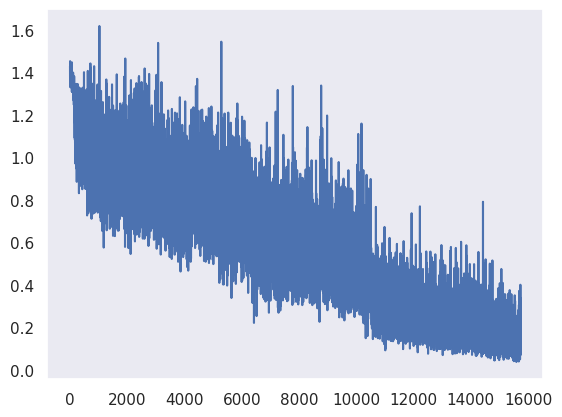

In [34]:
plt.plot(train_losses)

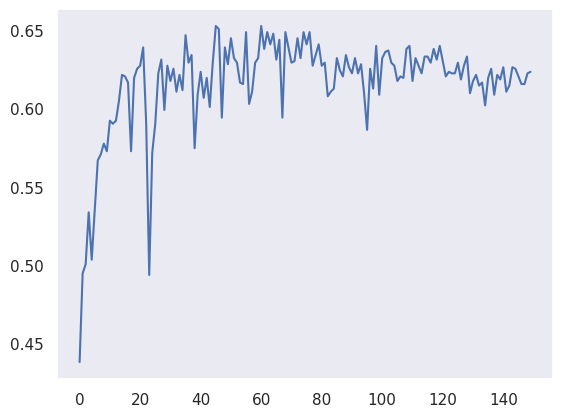

In [35]:
plt.plot(test_accuracy)

In [36]:
metrics4, confusion_matrix4 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics4.compute())
confusion_matrix4.compute()

Correct: 639/1024 (0.6240)
{'acc_detail': tensor([0.7180, 0.6344, 0.6604, 0.4850], device='cuda:0'),
 'acc_unweighted': tensor(0.6244, device='cuda:0'),
 'acc_weighted': tensor(0.6240, device='cuda:0'),
 'f1s': tensor(0.6233, device='cuda:0'),
 'f1s_detail': tensor([0.7127, 0.5614, 0.7071, 0.5119], device='cuda:0'),
 'precision_detail': tensor([0.7074, 0.5035, 0.7609, 0.5420], device='cuda:0'),
 'recall_detail': tensor([0.7180, 0.6344, 0.6604, 0.4850], device='cuda:0'),
 'rocauc': tensor([0.8786, 0.8356, 0.9040, 0.7616], device='cuda:0'),
 'uar': tensor(0.6244, device='cuda:0'),
 'wap': tensor(0.6331, device='cuda:0')}


tensor([[191,  22,   2,  51],
        [ 12, 144,  34,  37],
        [  5,  64, 175,  21],
        [ 62,  56,  19, 129]], device='cuda:0')

In [37]:
np.save('../cremad4_trill19_m12new_150epochs_train_losses.npy', train_losses, allow_pickle=True)
np.save('../cremad4_trill19_m12new_150epochs_test_accuracy.npy', test_accuracy, allow_pickle=True)

In [41]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 40
n_epoch4 = 50
n_epoch5 = 50
# train_losses = []
# test_accuracy = []

optimizer = optim.RAdam(model.parameters(), lr=0.000005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.005,
    steps_per_epoch=len(train_loader), epochs=n_epoch5)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch5) as pbar:
    for epoch in range(1+150, n_epoch5+150 + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                                                                                                                                              | 0.014598540145985401/50 [00:00<21:28, 25.79s/it]

Train Epoch: 151 [0/3387 (0%)]	Loss: 0.140205
Mem before-during-after: 21690368 517410304 22748672


  1%|█                                                                                                                                                                               | 0.3065693430656933/50 [00:08<21:33, 26.03s/it]

Train Epoch: 151 [1280/3387 (38%)]	Loss: 0.046862
Mem before-during-after: 22748672 518988800 22748672


  1%|██                                                                                                                                                                               | 0.598540145985401/50 [00:15<21:24, 25.99s/it]

Train Epoch: 151 [2560/3387 (76%)]	Loss: 0.069236
Mem before-during-after: 22748672 518988800 22748672


  2%|███▌                                                                                                                                                                            | 1.0072992700729917/50 [00:26<21:05, 25.83s/it]


Test Epoch: 151	Accuracy: 630/1024 (61%)

Train Epoch: 152 [0/3387 (0%)]	Loss: 0.078096
Mem before-during-after: 22744576 518464512 22748672


  3%|████▌                                                                                                                                                                           | 1.3065693430656966/50 [00:34<22:02, 27.16s/it]

Train Epoch: 152 [1280/3387 (38%)]	Loss: 0.039966
Mem before-during-after: 22748672 518988800 22748672


  3%|█████▋                                                                                                                                                                          | 1.5985401459854087/50 [00:41<20:57, 25.98s/it]

Train Epoch: 152 [2560/3387 (76%)]	Loss: 0.262062
Mem before-during-after: 22748672 518988800 22748672


  4%|███████                                                                                                                                                                         | 2.0072992700730055/50 [00:52<20:13, 25.28s/it]


Test Epoch: 152	Accuracy: 642/1024 (63%)

Train Epoch: 153 [0/3387 (0%)]	Loss: 0.054882
Mem before-during-after: 22744576 518464512 22748672


  5%|████████                                                                                                                                                                        | 2.3065693430657013/50 [01:00<20:40, 26.00s/it]

Train Epoch: 153 [1280/3387 (38%)]	Loss: 0.034243
Mem before-during-after: 22748672 518988800 22748672


  5%|█████████▏                                                                                                                                                                      | 2.5985401459854045/50 [01:07<20:50, 26.38s/it]

Train Epoch: 153 [2560/3387 (76%)]	Loss: 0.064680
Mem before-during-after: 22748672 518988800 22748672


  6%|██████████▋                                                                                                                                                                      | 3.007299270072989/50 [01:18<19:24, 24.78s/it]


Test Epoch: 153	Accuracy: 643/1024 (63%)

Train Epoch: 154 [0/3387 (0%)]	Loss: 0.036014
Mem before-during-after: 22744576 518464512 22748672


  7%|███████████▋                                                                                                                                                                     | 3.306569343065685/50 [01:25<19:59, 25.68s/it]

Train Epoch: 154 [1280/3387 (38%)]	Loss: 0.058789
Mem before-during-after: 22748672 518988800 22748672


  7%|████████████▋                                                                                                                                                                    | 3.598540145985388/50 [01:33<20:14, 26.17s/it]

Train Epoch: 154 [2560/3387 (76%)]	Loss: 0.113325
Mem before-during-after: 22748672 518988800 22748672


  8%|██████████████▏                                                                                                                                                                  | 4.007299270072973/50 [01:44<19:40, 25.66s/it]


Test Epoch: 154	Accuracy: 632/1024 (62%)

Train Epoch: 155 [0/3387 (0%)]	Loss: 0.055746
Mem before-during-after: 22744576 518464512 22748672


  9%|███████████████▏                                                                                                                                                                 | 4.306569343065687/50 [01:52<20:01, 26.30s/it]

Train Epoch: 155 [1280/3387 (38%)]	Loss: 0.119744
Mem before-during-after: 22748672 518988800 22748672


  9%|████████████████▎                                                                                                                                                                | 4.598540145985408/50 [01:59<19:55, 26.33s/it]

Train Epoch: 155 [2560/3387 (76%)]	Loss: 0.031091
Mem before-during-after: 22748672 518988800 22748672


 10%|█████████████████▋                                                                                                                                                               | 5.007299270073017/50 [02:10<18:47, 25.06s/it]


Test Epoch: 155	Accuracy: 644/1024 (63%)

Train Epoch: 156 [0/3387 (0%)]	Loss: 0.052085
Mem before-during-after: 22744576 518464512 22748672


 11%|██████████████████▊                                                                                                                                                              | 5.306569343065731/50 [02:18<19:17, 25.89s/it]

Train Epoch: 156 [1280/3387 (38%)]	Loss: 0.058183
Mem before-during-after: 22748672 518988800 22748672


 11%|███████████████████▊                                                                                                                                                             | 5.598540145985452/50 [02:25<19:17, 26.07s/it]

Train Epoch: 156 [2560/3387 (76%)]	Loss: 0.043574
Mem before-during-after: 22748672 518988800 22748672


 12%|█████████████████████▎                                                                                                                                                           | 6.007299270073061/50 [02:36<18:39, 25.44s/it]


Test Epoch: 156	Accuracy: 636/1024 (62%)

Train Epoch: 157 [0/3387 (0%)]	Loss: 0.046836
Mem before-during-after: 22744576 518464512 22748672


 13%|██████████████████████▎                                                                                                                                                          | 6.306569343065775/50 [02:43<19:03, 26.18s/it]

Train Epoch: 157 [1280/3387 (38%)]	Loss: 0.069741
Mem before-during-after: 22748672 518988800 22748672


 13%|███████████████████████▎                                                                                                                                                         | 6.598540145985496/50 [02:51<19:11, 26.53s/it]

Train Epoch: 157 [2560/3387 (76%)]	Loss: 0.071374
Mem before-during-after: 22748672 518988800 22748672


 14%|████████████████████████▊                                                                                                                                                        | 7.007299270073106/50 [03:02<17:55, 25.01s/it]


Test Epoch: 157	Accuracy: 622/1024 (61%)

Train Epoch: 158 [0/3387 (0%)]	Loss: 0.027428
Mem before-during-after: 22744576 518464512 22748672


 15%|██████████████████████████                                                                                                                                                        | 7.30656934306582/50 [03:09<18:19, 25.76s/it]

Train Epoch: 158 [1280/3387 (38%)]	Loss: 0.122794
Mem before-during-after: 22748672 518988800 22748672


 15%|██████████████████████████▉                                                                                                                                                      | 7.598540145985541/50 [03:17<18:14, 25.81s/it]

Train Epoch: 158 [2560/3387 (76%)]	Loss: 0.103435
Mem before-during-after: 22748672 518988800 22748672


 16%|████████████████████████████▌                                                                                                                                                     | 8.00729927007315/50 [03:27<17:34, 25.12s/it]


Test Epoch: 158	Accuracy: 632/1024 (62%)

Train Epoch: 159 [0/3387 (0%)]	Loss: 0.051456
Mem before-during-after: 22744576 518464512 22748672


 17%|█████████████████████████████▍                                                                                                                                                   | 8.306569343065863/50 [03:35<18:09, 26.13s/it]

Train Epoch: 159 [1280/3387 (38%)]	Loss: 0.128123
Mem before-during-after: 22748672 518988800 22748672


 17%|██████████████████████████████▍                                                                                                                                                  | 8.598540145985584/50 [03:43<17:48, 25.80s/it]

Train Epoch: 159 [2560/3387 (76%)]	Loss: 0.029275
Mem before-during-after: 22748672 518988800 22748672


 18%|███████████████████████████████▉                                                                                                                                                 | 9.007299270073194/50 [03:53<17:16, 25.28s/it]


Test Epoch: 159	Accuracy: 636/1024 (62%)

Train Epoch: 160 [0/3387 (0%)]	Loss: 0.100184
Mem before-during-after: 22744576 518464512 22748672


 19%|████████████████████████████████▉                                                                                                                                                | 9.306569343065908/50 [04:01<17:29, 25.80s/it]

Train Epoch: 160 [1280/3387 (38%)]	Loss: 0.084572
Mem before-during-after: 22748672 518988800 22748672


 19%|█████████████████████████████████▉                                                                                                                                               | 9.598540145985629/50 [04:08<17:17, 25.68s/it]

Train Epoch: 160 [2560/3387 (76%)]	Loss: 0.030623
Mem before-during-after: 22748672 518988800 22748672


 20%|███████████████████████████████████▏                                                                                                                                            | 10.007299270073238/50 [04:19<16:39, 24.98s/it]


Test Epoch: 160	Accuracy: 626/1024 (61%)

Train Epoch: 161 [0/3387 (0%)]	Loss: 0.078117
Mem before-during-after: 22744576 518464512 22748672


 21%|████████████████████████████████████▎                                                                                                                                           | 10.306569343065952/50 [04:26<17:01, 25.73s/it]

Train Epoch: 161 [1280/3387 (38%)]	Loss: 0.061893
Mem before-during-after: 22748672 518988800 22748672


 21%|█████████████████████████████████████▎                                                                                                                                          | 10.598540145985673/50 [04:34<17:01, 25.92s/it]

Train Epoch: 161 [2560/3387 (76%)]	Loss: 0.046084
Mem before-during-after: 22748672 518988800 22748672


 22%|██████████████████████████████████████▋                                                                                                                                         | 11.007299270073283/50 [04:44<17:11, 26.45s/it]


Test Epoch: 161	Accuracy: 629/1024 (61%)

Train Epoch: 162 [0/3387 (0%)]	Loss: 0.043098
Mem before-during-after: 22744576 518464512 22748672


 23%|███████████████████████████████████████▊                                                                                                                                        | 11.306569343065997/50 [04:52<17:23, 26.96s/it]

Train Epoch: 162 [1280/3387 (38%)]	Loss: 0.053249
Mem before-during-after: 22748672 518988800 22748672


 23%|████████████████████████████████████████▊                                                                                                                                       | 11.598540145985718/50 [05:00<16:55, 26.45s/it]

Train Epoch: 162 [2560/3387 (76%)]	Loss: 0.083616
Mem before-during-after: 22748672 518988800 22748672


 24%|██████████████████████████████████████████▎                                                                                                                                     | 12.007299270073327/50 [05:11<16:11, 25.56s/it]


Test Epoch: 162	Accuracy: 626/1024 (61%)

Train Epoch: 163 [0/3387 (0%)]	Loss: 0.076687
Mem before-during-after: 22744576 518464512 22748672


 25%|███████████████████████████████████████████▎                                                                                                                                    | 12.306569343066041/50 [05:19<16:13, 25.82s/it]

Train Epoch: 163 [1280/3387 (38%)]	Loss: 0.052817
Mem before-during-after: 22748672 518988800 22748672


 25%|████████████████████████████████████████████▎                                                                                                                                   | 12.598540145985762/50 [05:26<16:30, 26.48s/it]

Train Epoch: 163 [2560/3387 (76%)]	Loss: 0.033517
Mem before-during-after: 22748672 518988800 22748672


 26%|█████████████████████████████████████████████▊                                                                                                                                  | 13.007299270073371/50 [05:37<15:53, 25.78s/it]


Test Epoch: 163	Accuracy: 629/1024 (61%)

Train Epoch: 164 [0/3387 (0%)]	Loss: 0.252553
Mem before-during-after: 22744576 518464512 22748672


 27%|██████████████████████████████████████████████▊                                                                                                                                 | 13.306569343066085/50 [05:45<16:10, 26.45s/it]

Train Epoch: 164 [1280/3387 (38%)]	Loss: 0.032959
Mem before-during-after: 22748672 518988800 22748672


 27%|███████████████████████████████████████████████▊                                                                                                                                | 13.598540145985806/50 [05:53<15:50, 26.12s/it]

Train Epoch: 164 [2560/3387 (76%)]	Loss: 0.062972
Mem before-during-after: 22748672 518988800 22748672


 28%|█████████████████████████████████████████████████▎                                                                                                                              | 14.007299270073416/50 [06:03<15:16, 25.45s/it]


Test Epoch: 164	Accuracy: 630/1024 (61%)

Train Epoch: 165 [0/3387 (0%)]	Loss: 0.100161
Mem before-during-after: 22744576 518464512 22748672


 29%|██████████████████████████████████████████████████▋                                                                                                                              | 14.30656934306613/50 [06:11<15:41, 26.39s/it]

Train Epoch: 165 [1280/3387 (38%)]	Loss: 0.067356
Mem before-during-after: 22748672 518988800 22748672


 29%|███████████████████████████████████████████████████▋                                                                                                                             | 14.59854014598585/50 [06:19<15:35, 26.41s/it]

Train Epoch: 165 [2560/3387 (76%)]	Loss: 0.123020
Mem before-during-after: 22748672 518988800 22748672


 30%|█████████████████████████████████████████████████████▏                                                                                                                           | 15.00729927007346/50 [06:29<14:36, 25.05s/it]


Test Epoch: 165	Accuracy: 638/1024 (62%)

Train Epoch: 166 [0/3387 (0%)]	Loss: 0.150920
Mem before-during-after: 22744576 518464512 22748672


 31%|█████████████████████████████████████████████████████▉                                                                                                                          | 15.306569343066174/50 [06:37<15:05, 26.09s/it]

Train Epoch: 166 [1280/3387 (38%)]	Loss: 0.043483
Mem before-during-after: 22748672 518988800 22748672


 31%|██████████████████████████████████████████████████████▉                                                                                                                         | 15.598540145985895/50 [06:45<15:17, 26.66s/it]

Train Epoch: 166 [2560/3387 (76%)]	Loss: 0.045405
Mem before-during-after: 22748672 518988800 22748672


 32%|████████████████████████████████████████████████████████▎                                                                                                                       | 16.007299270073503/50 [06:55<14:18, 25.25s/it]


Test Epoch: 166	Accuracy: 631/1024 (62%)

Train Epoch: 167 [0/3387 (0%)]	Loss: 0.061543
Mem before-during-after: 22744576 518464512 22748672


 33%|█████████████████████████████████████████████████████████▍                                                                                                                      | 16.306569343066144/50 [07:03<14:51, 26.45s/it]

Train Epoch: 167 [1280/3387 (38%)]	Loss: 0.045858
Mem before-during-after: 22748672 518988800 22748672


 33%|██████████████████████████████████████████████████████████▍                                                                                                                     | 16.598540145985794/50 [07:11<14:27, 25.97s/it]

Train Epoch: 167 [2560/3387 (76%)]	Loss: 0.133546
Mem before-during-after: 22748672 518988800 22748672


 34%|███████████████████████████████████████████████████████████▊                                                                                                                    | 17.007299270073304/50 [07:21<13:40, 24.88s/it]


Test Epoch: 167	Accuracy: 635/1024 (62%)

Train Epoch: 168 [0/3387 (0%)]	Loss: 0.084220
Mem before-during-after: 22744576 518464512 22748672


 35%|████████████████████████████████████████████████████████████▉                                                                                                                   | 17.306569343065945/50 [07:29<14:22, 26.39s/it]

Train Epoch: 168 [1280/3387 (38%)]	Loss: 0.059691
Mem before-during-after: 22748672 518988800 22748672


 35%|█████████████████████████████████████████████████████████████▉                                                                                                                  | 17.598540145985595/50 [07:37<14:00, 25.94s/it]

Train Epoch: 168 [2560/3387 (76%)]	Loss: 0.058412
Mem before-during-after: 22748672 518988800 22748672


 36%|███████████████████████████████████████████████████████████████▍                                                                                                                | 18.007299270073105/50 [07:47<13:32, 25.39s/it]


Test Epoch: 168	Accuracy: 620/1024 (60%)

Train Epoch: 169 [0/3387 (0%)]	Loss: 0.100399
Mem before-during-after: 22744576 518464512 22748672


 37%|████████████████████████████████████████████████████████████████▍                                                                                                               | 18.306569343065746/50 [07:55<13:56, 26.41s/it]

Train Epoch: 169 [1280/3387 (38%)]	Loss: 0.077154
Mem before-during-after: 22748672 518988800 22748672


 37%|█████████████████████████████████████████████████████████████████▍                                                                                                              | 18.598540145985396/50 [08:02<13:40, 26.13s/it]

Train Epoch: 169 [2560/3387 (76%)]	Loss: 0.078772
Mem before-during-after: 22748672 518988800 22748672


 38%|██████████████████████████████████████████████████████████████████▉                                                                                                             | 19.007299270072906/50 [08:13<12:53, 24.95s/it]


Test Epoch: 169	Accuracy: 629/1024 (61%)

Train Epoch: 170 [0/3387 (0%)]	Loss: 0.096928
Mem before-during-after: 22744576 518464512 22748672


 39%|███████████████████████████████████████████████████████████████████▉                                                                                                            | 19.306569343065547/50 [08:21<13:19, 26.04s/it]

Train Epoch: 170 [1280/3387 (38%)]	Loss: 0.065725
Mem before-during-after: 22748672 518988800 22748672


 39%|████████████████████████████████████████████████████████████████████▉                                                                                                           | 19.598540145985197/50 [08:28<13:09, 25.98s/it]

Train Epoch: 170 [2560/3387 (76%)]	Loss: 0.053167
Mem before-during-after: 22748672 518988800 22748672


 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                         | 20.007299270072707/50 [08:39<12:37, 25.27s/it]


Test Epoch: 170	Accuracy: 625/1024 (61%)

Train Epoch: 171 [0/3387 (0%)]	Loss: 0.065426
Mem before-during-after: 22744576 518464512 22748672


 41%|███████████████████████████████████████████████████████████████████████▍                                                                                                        | 20.306569343065348/50 [08:46<12:59, 26.26s/it]

Train Epoch: 171 [1280/3387 (38%)]	Loss: 0.083394
Mem before-during-after: 22748672 518988800 22748672


 41%|████████████████████████████████████████████████████████████████████████▌                                                                                                       | 20.598540145984998/50 [08:54<12:46, 26.08s/it]

Train Epoch: 171 [2560/3387 (76%)]	Loss: 0.063812
Mem before-during-after: 22748672 518988800 22748672


 42%|█████████████████████████████████████████████████████████████████████████▉                                                                                                      | 21.007299270072508/50 [09:04<12:15, 25.35s/it]


Test Epoch: 171	Accuracy: 632/1024 (62%)

Train Epoch: 172 [0/3387 (0%)]	Loss: 0.091853
Mem before-during-after: 22744576 518464512 22748672


 43%|███████████████████████████████████████████████████████████████████████████▍                                                                                                     | 21.30656934306515/50 [09:12<12:35, 26.32s/it]

Train Epoch: 172 [1280/3387 (38%)]	Loss: 0.057402
Mem before-during-after: 22748672 518988800 22748672


 43%|████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 21.5985401459848/50 [09:20<12:27, 26.33s/it]

Train Epoch: 172 [2560/3387 (76%)]	Loss: 0.078786
Mem before-during-after: 22748672 518988800 22748672


 44%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 22.00729927007231/50 [09:31<12:01, 25.78s/it]


Test Epoch: 172	Accuracy: 629/1024 (61%)

Train Epoch: 173 [0/3387 (0%)]	Loss: 0.065077
Mem before-during-after: 22744576 518464512 22748672


 45%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 22.30656934306495/50 [09:38<12:06, 26.25s/it]

Train Epoch: 173 [1280/3387 (38%)]	Loss: 0.066519
Mem before-during-after: 22748672 518988800 22748672


 45%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 22.5985401459846/50 [09:46<12:09, 26.64s/it]

Train Epoch: 173 [2560/3387 (76%)]	Loss: 0.124849
Mem before-during-after: 22748672 518988800 22748672


 46%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 23.00729927007211/50 [09:57<11:33, 25.67s/it]


Test Epoch: 173	Accuracy: 629/1024 (61%)

Train Epoch: 174 [0/3387 (0%)]	Loss: 0.104066
Mem before-during-after: 22744576 518464512 22748672


 47%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 23.30656934306475/50 [10:05<11:42, 26.32s/it]

Train Epoch: 174 [1280/3387 (38%)]	Loss: 0.074399
Mem before-during-after: 22748672 518988800 22748672


 47%|████████████████████████████████████████████████████████████████████████████████████                                                                                              | 23.5985401459844/50 [10:12<11:25, 25.98s/it]

Train Epoch: 174 [2560/3387 (76%)]	Loss: 0.049098
Mem before-during-after: 22748672 518988800 22748672


 48%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 24.00729927007191/50 [10:23<10:48, 24.94s/it]


Test Epoch: 174	Accuracy: 629/1024 (61%)

Train Epoch: 175 [0/3387 (0%)]	Loss: 0.089831
Mem before-during-after: 22744576 518464512 22748672


 49%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 24.306569343064552/50 [10:31<11:16, 26.33s/it]

Train Epoch: 175 [1280/3387 (38%)]	Loss: 0.114014
Mem before-during-after: 22748672 518988800 22748672


 49%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 24.598540145984202/50 [10:38<11:01, 26.03s/it]

Train Epoch: 175 [2560/3387 (76%)]	Loss: 0.061854
Mem before-during-after: 22748672 518988800 22748672


 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 25.007299270071712/50 [10:48<10:27, 25.10s/it]


Test Epoch: 175	Accuracy: 630/1024 (61%)

Train Epoch: 176 [0/3387 (0%)]	Loss: 0.071782
Mem before-during-after: 22744576 518464512 22748672


 51%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 25.306569343064353/50 [10:56<10:39, 25.90s/it]

Train Epoch: 176 [1280/3387 (38%)]	Loss: 0.083590
Mem before-during-after: 22748672 518988800 22748672


 51%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 25.598540145984003/50 [11:04<10:29, 25.81s/it]

Train Epoch: 176 [2560/3387 (76%)]	Loss: 0.023336
Mem before-during-after: 22748672 518988800 22748672


 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 26.007299270071513/50 [11:14<09:56, 24.84s/it]


Test Epoch: 176	Accuracy: 632/1024 (62%)

Train Epoch: 177 [0/3387 (0%)]	Loss: 0.027571
Mem before-during-after: 22744576 518464512 22748672


 53%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 26.306569343064155/50 [11:22<10:19, 26.16s/it]

Train Epoch: 177 [1280/3387 (38%)]	Loss: 0.032625
Mem before-during-after: 22748672 518988800 22748672


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 26.598540145983804/50 [11:30<10:05, 25.87s/it]

Train Epoch: 177 [2560/3387 (76%)]	Loss: 0.057487
Mem before-during-after: 22748672 518988800 22748672


 54%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 27.007299270071314/50 [11:40<09:30, 24.81s/it]


Test Epoch: 177	Accuracy: 634/1024 (62%)

Train Epoch: 178 [0/3387 (0%)]	Loss: 0.040286
Mem before-during-after: 22744576 518464512 22748672


 55%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 27.306569343063956/50 [11:48<10:03, 26.58s/it]

Train Epoch: 178 [1280/3387 (38%)]	Loss: 0.144521
Mem before-during-after: 22748672 518988800 22748672


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 27.598540145983605/50 [11:56<09:39, 25.85s/it]

Train Epoch: 178 [2560/3387 (76%)]	Loss: 0.062460
Mem before-during-after: 22748672 518988800 22748672


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 28.007299270071115/50 [12:06<09:10, 25.03s/it]


Test Epoch: 178	Accuracy: 623/1024 (61%)

Train Epoch: 179 [0/3387 (0%)]	Loss: 0.099338
Mem before-during-after: 22744576 518464512 22748672


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 28.306569343063757/50 [12:14<09:21, 25.88s/it]

Train Epoch: 179 [1280/3387 (38%)]	Loss: 0.077348
Mem before-during-after: 22748672 518988800 22748672


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 28.598540145983407/50 [12:21<09:13, 25.84s/it]

Train Epoch: 179 [2560/3387 (76%)]	Loss: 0.051023
Mem before-during-after: 22748672 518988800 22748672


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 29.007299270070916/50 [12:32<08:38, 24.70s/it]


Test Epoch: 179	Accuracy: 636/1024 (62%)

Train Epoch: 180 [0/3387 (0%)]	Loss: 0.059708
Mem before-during-after: 22744576 518464512 22748672


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 29.306569343063558/50 [12:39<08:56, 25.92s/it]

Train Epoch: 180 [1280/3387 (38%)]	Loss: 0.067600
Mem before-during-after: 22748672 518988800 22748672


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 29.598540145983208/50 [12:47<08:51, 26.06s/it]

Train Epoch: 180 [2560/3387 (76%)]	Loss: 0.083712
Mem before-during-after: 22748672 518988800 22748672


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 30.007299270070718/50 [12:57<08:19, 24.98s/it]


Test Epoch: 180	Accuracy: 639/1024 (62%)

Train Epoch: 181 [0/3387 (0%)]	Loss: 0.056454
Mem before-during-after: 22744576 518464512 22748672


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 30.30656934306336/50 [13:05<08:28, 25.83s/it]

Train Epoch: 181 [1280/3387 (38%)]	Loss: 0.111098
Mem before-during-after: 22748672 518988800 22748672


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 30.59854014598301/50 [13:13<08:22, 25.93s/it]

Train Epoch: 181 [2560/3387 (76%)]	Loss: 0.073307
Mem before-during-after: 22748672 518988800 22748672


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 31.00729927007052/50 [13:23<07:58, 25.20s/it]


Test Epoch: 181	Accuracy: 634/1024 (62%)

Train Epoch: 182 [0/3387 (0%)]	Loss: 0.035347
Mem before-during-after: 22744576 518464512 22748672


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 31.30656934306316/50 [13:31<08:04, 25.93s/it]

Train Epoch: 182 [1280/3387 (38%)]	Loss: 0.024926
Mem before-during-after: 22748672 518988800 22748672


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 31.59854014598281/50 [13:38<07:58, 25.99s/it]

Train Epoch: 182 [2560/3387 (76%)]	Loss: 0.127104
Mem before-during-after: 22748672 518988800 22748672


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 32.00729927007032/50 [13:48<07:30, 25.01s/it]


Test Epoch: 182	Accuracy: 615/1024 (60%)

Train Epoch: 183 [0/3387 (0%)]	Loss: 0.061255
Mem before-during-after: 22744576 518464512 22748672


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 32.30656934306296/50 [13:56<07:40, 26.02s/it]

Train Epoch: 183 [1280/3387 (38%)]	Loss: 0.115331
Mem before-during-after: 22748672 518988800 22748672


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 32.59854014598261/50 [14:04<07:31, 25.96s/it]

Train Epoch: 183 [2560/3387 (76%)]	Loss: 0.074242
Mem before-during-after: 22748672 518988800 22748672


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 33.00729927007012/50 [14:14<07:03, 24.94s/it]


Test Epoch: 183	Accuracy: 632/1024 (62%)

Train Epoch: 184 [0/3387 (0%)]	Loss: 0.030009
Mem before-during-after: 22744576 518464512 22748672


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 33.30656934306276/50 [14:22<07:18, 26.25s/it]

Train Epoch: 184 [1280/3387 (38%)]	Loss: 0.030142
Mem before-during-after: 22748672 518988800 22748672


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 33.59854014598241/50 [14:30<07:14, 26.47s/it]

Train Epoch: 184 [2560/3387 (76%)]	Loss: 0.069231
Mem before-during-after: 22748672 518988800 22748672


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 34.00729927006992/50 [14:40<06:42, 25.15s/it]


Test Epoch: 184	Accuracy: 629/1024 (61%)

Train Epoch: 185 [0/3387 (0%)]	Loss: 0.031156
Mem before-during-after: 22744576 518464512 22748672


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 34.30656934306256/50 [14:48<06:52, 26.30s/it]

Train Epoch: 185 [1280/3387 (38%)]	Loss: 0.167410
Mem before-during-after: 22748672 518988800 22748672


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 34.59854014598221/50 [14:56<06:44, 26.25s/it]

Train Epoch: 185 [2560/3387 (76%)]	Loss: 0.052345
Mem before-during-after: 22748672 518988800 22748672


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 35.00729927006972/50 [15:06<06:17, 25.21s/it]


Test Epoch: 185	Accuracy: 628/1024 (61%)

Train Epoch: 186 [0/3387 (0%)]	Loss: 0.037835
Mem before-during-after: 22744576 518464512 22748672


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 35.306569343062364/50 [15:14<06:21, 25.99s/it]

Train Epoch: 186 [1280/3387 (38%)]	Loss: 0.086418
Mem before-during-after: 22748672 518988800 22748672


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 35.598540145982014/50 [15:22<06:13, 25.94s/it]

Train Epoch: 186 [2560/3387 (76%)]	Loss: 0.073599
Mem before-during-after: 22748672 518988800 22748672


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 36.007299270069524/50 [15:32<05:49, 25.00s/it]


Test Epoch: 186	Accuracy: 642/1024 (63%)

Train Epoch: 187 [0/3387 (0%)]	Loss: 0.052041
Mem before-during-after: 22744576 518464512 22748672


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 36.306569343062165/50 [15:40<05:53, 25.78s/it]

Train Epoch: 187 [1280/3387 (38%)]	Loss: 0.138727
Mem before-during-after: 22748672 518988800 22748672


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 36.598540145981815/50 [15:47<05:51, 26.22s/it]

Train Epoch: 187 [2560/3387 (76%)]	Loss: 0.089057
Mem before-during-after: 22748672 518988800 22748672


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 37.007299270069325/50 [15:58<05:23, 24.92s/it]


Test Epoch: 187	Accuracy: 618/1024 (60%)

Train Epoch: 188 [0/3387 (0%)]	Loss: 0.050165
Mem before-during-after: 22744576 518464512 22748672


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 37.306569343061966/50 [16:05<05:28, 25.90s/it]

Train Epoch: 188 [1280/3387 (38%)]	Loss: 0.083414
Mem before-during-after: 22748672 518988800 22748672


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 37.598540145981616/50 [16:13<05:22, 26.02s/it]

Train Epoch: 188 [2560/3387 (76%)]	Loss: 0.121813
Mem before-during-after: 22748672 518988800 22748672


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 38.007299270069126/50 [16:23<04:58, 24.89s/it]


Test Epoch: 188	Accuracy: 644/1024 (63%)

Train Epoch: 189 [0/3387 (0%)]	Loss: 0.010990
Mem before-during-after: 22744576 518464512 22748672


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 38.30656934306177/50 [16:31<05:08, 26.39s/it]

Train Epoch: 189 [1280/3387 (38%)]	Loss: 0.019429
Mem before-during-after: 22748672 518988800 22748672


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 38.59854014598142/50 [16:39<04:55, 25.92s/it]

Train Epoch: 189 [2560/3387 (76%)]	Loss: 0.143131
Mem before-during-after: 22748672 518988800 22748672


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 39.00729927006893/50 [16:49<04:34, 24.94s/it]


Test Epoch: 189	Accuracy: 640/1024 (62%)

Train Epoch: 190 [0/3387 (0%)]	Loss: 0.084976
Mem before-during-after: 22744576 518464512 22748672


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 39.30656934306157/50 [16:57<04:39, 26.13s/it]

Train Epoch: 190 [1280/3387 (38%)]	Loss: 0.066495
Mem before-during-after: 22748672 518988800 22748672


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 39.59854014598122/50 [17:05<04:32, 26.23s/it]

Train Epoch: 190 [2560/3387 (76%)]	Loss: 0.170609
Mem before-during-after: 22748672 518988800 22748672


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 40.00729927006873/50 [17:15<04:11, 25.17s/it]


Test Epoch: 190	Accuracy: 618/1024 (60%)

Train Epoch: 191 [0/3387 (0%)]	Loss: 0.102144
Mem before-during-after: 22744576 518464512 22748672


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 40.30656934306137/50 [17:23<04:14, 26.29s/it]

Train Epoch: 191 [1280/3387 (38%)]	Loss: 0.059662
Mem before-during-after: 22748672 518988800 22748672


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 40.59854014598102/50 [17:31<04:05, 26.10s/it]

Train Epoch: 191 [2560/3387 (76%)]	Loss: 0.128702
Mem before-during-after: 22748672 518988800 22748672


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 41.00729927006853/50 [17:41<03:42, 24.80s/it]


Test Epoch: 191	Accuracy: 623/1024 (61%)

Train Epoch: 192 [0/3387 (0%)]	Loss: 0.055094
Mem before-during-after: 22744576 518464512 22748672


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 41.30656934306117/50 [17:49<03:46, 26.01s/it]

Train Epoch: 192 [1280/3387 (38%)]	Loss: 0.069222
Mem before-during-after: 22748672 518988800 22748672


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 41.59854014598082/50 [17:56<03:40, 26.23s/it]

Train Epoch: 192 [2560/3387 (76%)]	Loss: 0.076010
Mem before-during-after: 22748672 518988800 22748672


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 42.00729927006833/50 [18:07<03:22, 25.32s/it]


Test Epoch: 192	Accuracy: 633/1024 (62%)

Train Epoch: 193 [0/3387 (0%)]	Loss: 0.036046
Mem before-during-after: 22744576 518464512 22748672


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 42.30656934306097/50 [18:15<03:22, 26.30s/it]

Train Epoch: 193 [1280/3387 (38%)]	Loss: 0.021278
Mem before-during-after: 22748672 518988800 22748672


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 42.59854014598062/50 [18:22<03:14, 26.26s/it]

Train Epoch: 193 [2560/3387 (76%)]	Loss: 0.027746
Mem before-during-after: 22748672 518988800 22748672


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 43.00729927006813/50 [18:33<02:56, 25.28s/it]


Test Epoch: 193	Accuracy: 626/1024 (61%)

Train Epoch: 194 [0/3387 (0%)]	Loss: 0.067002
Mem before-during-after: 22744576 518464512 22748672


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 43.30656934306077/50 [18:41<02:55, 26.26s/it]

Train Epoch: 194 [1280/3387 (38%)]	Loss: 0.094691
Mem before-during-after: 22748672 518988800 22748672


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 43.59854014598042/50 [18:48<02:48, 26.29s/it]

Train Epoch: 194 [2560/3387 (76%)]	Loss: 0.061646
Mem before-during-after: 22748672 518988800 22748672


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 44.00729927006793/50 [18:59<02:31, 25.30s/it]


Test Epoch: 194	Accuracy: 642/1024 (63%)

Train Epoch: 195 [0/3387 (0%)]	Loss: 0.056257
Mem before-during-after: 22744576 518464512 22748672


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 44.30656934306057/50 [19:07<02:29, 26.34s/it]

Train Epoch: 195 [1280/3387 (38%)]	Loss: 0.175840
Mem before-during-after: 22748672 518988800 22748672


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 44.59854014598022/50 [19:14<02:20, 25.94s/it]

Train Epoch: 195 [2560/3387 (76%)]	Loss: 0.057612
Mem before-during-after: 22748672 518988800 22748672


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 45.00729927006773/50 [19:25<02:07, 25.46s/it]


Test Epoch: 195	Accuracy: 636/1024 (62%)

Train Epoch: 196 [0/3387 (0%)]	Loss: 0.088135
Mem before-during-after: 22744576 518464512 22748672


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 45.306569343060374/50 [19:32<02:02, 26.05s/it]

Train Epoch: 196 [1280/3387 (38%)]	Loss: 0.092799
Mem before-during-after: 22748672 518988800 22748672


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 45.598540145980024/50 [19:40<01:53, 25.80s/it]

Train Epoch: 196 [2560/3387 (76%)]	Loss: 0.095985
Mem before-during-after: 22748672 518988800 22748672


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 46.007299270067534/50 [19:50<01:38, 24.76s/it]


Test Epoch: 196	Accuracy: 624/1024 (61%)

Train Epoch: 197 [0/3387 (0%)]	Loss: 0.039459
Mem before-during-after: 22744576 518464512 22748672


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 46.306569343060175/50 [19:58<01:35, 25.90s/it]

Train Epoch: 197 [1280/3387 (38%)]	Loss: 0.052995
Mem before-during-after: 22748672 518988800 22748672


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 46.598540145979825/50 [20:06<01:29, 26.19s/it]

Train Epoch: 197 [2560/3387 (76%)]	Loss: 0.092979
Mem before-during-after: 22748672 518988800 22748672


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 46.999999999994344/50 [20:16<01:14, 24.77s/it]


Test Epoch: 197	Accuracy: 633/1024 (62%)



 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 47.01459854014033/50 [20:16<01:17, 26.01s/it]

Train Epoch: 198 [0/3387 (0%)]	Loss: 0.034971
Mem before-during-after: 22744576 518464512 22748672


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 47.30656934305998/50 [20:24<01:11, 26.39s/it]

Train Epoch: 198 [1280/3387 (38%)]	Loss: 0.009276
Mem before-during-after: 22748672 518988800 22748672


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 47.59854014597963/50 [20:32<01:03, 26.33s/it]

Train Epoch: 198 [2560/3387 (76%)]	Loss: 0.024039
Mem before-during-after: 22748672 518988800 22748672


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 48.007299270067136/50 [20:42<00:50, 25.43s/it]


Test Epoch: 198	Accuracy: 634/1024 (62%)

Train Epoch: 199 [0/3387 (0%)]	Loss: 0.011873
Mem before-during-after: 22744576 518464512 22748672


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 48.30656934305978/50 [20:50<00:44, 26.56s/it]

Train Epoch: 199 [1280/3387 (38%)]	Loss: 0.285994
Mem before-during-after: 22748672 518988800 22748672


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 48.59854014597943/50 [20:58<00:37, 26.59s/it]

Train Epoch: 199 [2560/3387 (76%)]	Loss: 0.023114
Mem before-during-after: 22748672 518988800 22748672


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 49.00729927006694/50 [21:08<00:25, 25.47s/it]


Test Epoch: 199	Accuracy: 634/1024 (62%)

Train Epoch: 200 [0/3387 (0%)]	Loss: 0.067617
Mem before-during-after: 22744576 518464512 22748672


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 49.30656934305958/50 [21:16<00:18, 26.30s/it]

Train Epoch: 200 [1280/3387 (38%)]	Loss: 0.042069
Mem before-during-after: 22748672 518988800 22748672


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 49.59854014597923/50 [21:24<00:10, 26.76s/it]

Train Epoch: 200 [2560/3387 (76%)]	Loss: 0.018365
Mem before-during-after: 22748672 518988800 22748672


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 49.99999999999375/50 [21:34<00:00, 25.89s/it]


Test Epoch: 200	Accuracy: 618/1024 (60%)



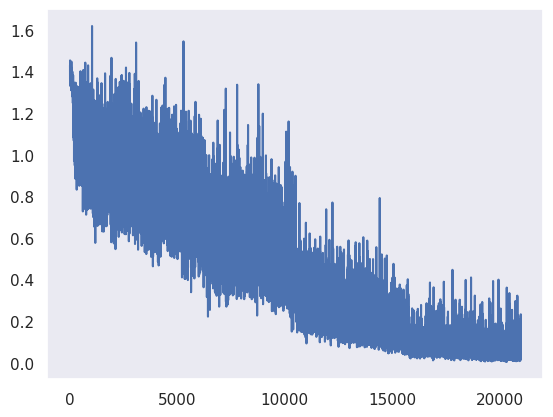

In [42]:
plt.plot(train_losses)

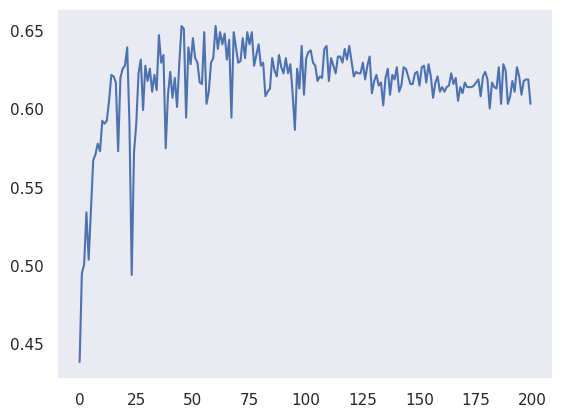

In [43]:
plt.plot(test_accuracy)

In [44]:
best_accuracy

0.6526829268292683

In [45]:
metrics5, confusion_matrix5 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics5.compute())
confusion_matrix5.compute()

Correct: 618/1024 (0.6035)
{'acc_detail': tensor([0.6165, 0.5419, 0.7094, 0.5376], device='cuda:0'),
 'acc_unweighted': tensor(0.6014, device='cuda:0'),
 'acc_weighted': tensor(0.6035, device='cuda:0'),
 'f1s': tensor(0.6034, device='cuda:0'),
 'f1s_detail': tensor([0.6763, 0.5348, 0.6899, 0.5125], device='cuda:0'),
 'precision_detail': tensor([0.7489, 0.5279, 0.6714, 0.4897], device='cuda:0'),
 'recall_detail': tensor([0.6165, 0.5419, 0.7094, 0.5376], device='cuda:0'),
 'rocauc': tensor([0.8645, 0.8398, 0.9025, 0.7547], device='cuda:0'),
 'uar': tensor(0.6014, device='cuda:0'),
 'wap': tensor(0.6125, device='cuda:0')}


tensor([[164,  21,   4,  77],
        [  8, 123,  49,  47],
        [  1,  51, 188,  25],
        [ 46,  38,  39, 143]], device='cuda:0')

In [46]:
model.to('cpu')

M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2OneBlocks(
    (blocks): LSTM(97, 48, batch_first=True)
  )
  (cls_hea

In [47]:
np.save('../cremad4_m12new_trill19_2000epochs_train_losses.npy', train_losses, allow_pickle=True)
np.save('../cremad4_m12new_trill19_200epochs_test_accuracy.npy', test_accuracy, allow_pickle=True)